versions of module used for development:
Python version: 3.10.13 | packaged by conda-forge | (main, Oct 26 2023, 18:07:37) [GCC 12.3.0]
numpy version: 1.26.3
pandas version: 2.1.1
sklearn version: 1.3.2
statsmodels version: 0.14.0
colorama version: 0.4.4
matplotlib version: 3.8.0
re version: 2.2.1
pickle version: 4.0

!pip install numpy==1.26.3 pandas==2.1.1 scikit-learn==1.3.2 statsmodels==0.14.0 colorama==0.4.4 matplotlib==3.8.0 pickle==4.0

In [1]:
import numpy as np
import pandas as pd
import warnings
import os, re, math, time
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from colorama import Fore
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import pickle

import sklearn
import statsmodels
import colorama
import matplotlib
import sys

warnings.filterwarnings("ignore")

In [2]:
# import file with all input data
pd.set_option('display.max_columns', 20)

df=pd.read_parquet('s3://576118004139-ap-south-1-kbl-datamart-l2/datamartl2/collection_prioritization_v2/cp_features_dcp_v10/20240707_124928_00016_edqr2_e2cd4162-8709-4feb-a239-e73ee74d5713')
df=df[df['hl_present'].notnull()]
# above filter is proxy to remove bureau missing customers

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df['td_flag']=np.where(df['avg_td_1m'].isnull(),0,1)
df['max_follow_up_l1m_A002']=np.where(df['max_follow_up_l1m']=='A002',1,0)
df['max_follow_up_l1m_A005']=np.where(df['max_follow_up_l1m']=='A005',1,0)
df['']=np.where(df['max_follow_up_l1m']=='A005',1,0)

df['snap_dt']=df['snap_dt'].astype(str)
df=df.rename(columns={'bad':'good'})
df['stress_cat_1to30']=np.where(df['stress_cat_day0']=='SMA0',1,0)
df['stress_cat_31to60']=np.where(df['stress_cat_day0']=='SMA1',1,0)
df['stress_cat_61to90']=np.where(df['stress_cat_day0']=='SMA2',1,0)

df_dev=df[df['dev']=='1']
# stress_cat_day0,
# stress_days_day0,


df_oot=df[(df['dev']=='0') & (df['snap_dt'].isin(["2023-01-31",'2023-12-31','2024-01-31','2024-02-29','2024-03-31'])) ]

# df_dev.head()
# df_train=df_dev[df_dev['snap_dt'].isin()]




In [3]:
df_dev['good'].value_counts()

good
0    20981
1    20872
Name: count, dtype: int64

In [4]:
df_oot['good'].value_counts()

good
1    25223
0    24546
Name: count, dtype: int64

In [5]:
df_dev[df_dev['hl_present'].notnull()].shape


(41853, 438)

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df_dev.describe()

good  active_loans  active_loans_sanctions  \
count  41853.000000  41853.000000            41853.000000   
mean       0.498698      3.951401                3.609586   
min        0.000000      1.000000                1.000000   
25%        0.000000      1.000000                1.000000   
50%        0.000000      1.000000                1.000000   
75%        1.000000      4.000000                4.000000   
max        1.000000   1020.000000              867.000000   
std        0.500004     14.752019               12.900685   

       active_oda_sanctions  avg_followups_perdelq_l1m  \
count          41853.000000               40968.000000   
mean               0.341768                   1.376995   
min                0.000000                   1.000000   
25%                0.000000                   1.111111   
50%                0.000000                   1.333333   
75%                0.000000                   1.538462   
max              153.000000                   7.000000   
std                2.265175                   0.352399   

       avg_followups_perdelq_l3m  avg_followups_perdelq_l6m  \
count               41231.000000               41383.000000   
mean                    1.382853                   1.385628   
min                     1.000000                   1.000000   
25%                     1.142857                   1.166667   
50%                     1.333333                   1.333333   
75%                     1.533333                   1.523810   
max                     7.000000                   7.000000   
std                     0.329435                   0.315002   

       cnt_12m_loan_closed  cnt_12m_loan_opened  cnt_3m_loan_closed  \
count          6419.000000          9036.000000         1883.000000   
mean              2.927403             2.519146            2.317578   
min               1.000000             1.000000            1.000000   
25%               1.000000             1.000000            1.000000   
50%               2.000000             1.000000            2.000000   
75%               3.000000             2.000000            2.000000   
max              96.000000           144.000000           42.000000   
std               3.969582             4.189767            2.708087   

       cnt_3m_loan_opened  cnt_6m_loan_closed  cnt_6m_loan_opened  \
count         2335.000000         3667.000000         4719.000000   
mean             2.039829            2.526043            2.262768   
min              1.000000            1.000000            1.000000   
25%              1.000000            1.000000            1.000000   
50%              1.000000            2.000000            1.000000   
75%              2.000000            3.000000            2.000000   
max             65.000000           56.000000           72.000000   
std              2.933956            3.131082            3.397883   

       cnt_loan_opened  customer_age  customer_vintage  days_in_stress_l12m  \
count     41853.000000  41853.000000      40298.000000         41853.000000   
mean         12.458175     45.417557        113.397365           170.208492   
min           1.000000     18.000000        -15.000000             1.000000   
25%           1.000000     37.000000         60.000000            63.000000   
50%           2.000000     45.000000         98.000000           158.000000   
75%           6.000000     53.000000        148.000000           284.000000   
max        5880.000000     94.000000       1119.000000           337.000000   
std          76.251563     11.735512         76.284509           114.753249   

       days_in_stress_l3m  days_in_stress_l6m  inward_chq_bounce_l12m_flag  \
count        41853.000000        41853.000000                 41853.000000   
mean            41.496189           89.672974                     0.279598   
min              1.000000            1.000000                     0.000000   
25%             21.000000           38.000000                     0.000000   
50%       

In [7]:
df_dev['snap_dt'].value_counts()

snap_dt
2023-10-31    9710
2023-08-31    9340
2023-04-30    8124
2023-06-30    7685
2023-02-28    6994
Name: count, dtype: int64

In [8]:
df_oot['snap_dt'].value_counts()

snap_dt
2024-03-31    11580
2024-02-29    10662
2023-12-31    10017
2024-01-31     9868
2023-01-31     7642
Name: count, dtype: int64

In [9]:
df_dev['stress_cat_day0'].value_counts()

stress_cat_day0
SMA0    23433
SMA2     9963
SMA1     8457
Name: count, dtype: int64

In [10]:
# data type conversions

dtype_dict={
'cust_id' : 'str',
'snap_dt' : 'str',
'good' : 'int32',
'dev' : 'str',
'stress_cat_1to30':'int32',
'stress_cat_31to60':'int32',
'stress_cat_61to90':'int32',
# 'oot' : 'str',
'active_loans' : 'int64',
'active_loans_outstanding' : 'float64',
'active_loans_sanctions' : 'int64',
'active_oda_outstanding' : 'float64',
'active_oda_sanctions' : 'int64',
'avg_followups_perdelq_l1m' : 'float64',
'avg_followups_perdelq_l3m' : 'float64',
'avg_followups_perdelq_l6m' : 'float64',
'avg_mab_12m' : 'float64',
'avg_mab_1m' : 'float64',
'avg_mab_3m' : 'float64',
'avg_mab_6m' : 'float64',
'avg_td_12m' : 'float64',
'avg_td_1m' : 'float64',
'avg_td_3m' : 'float64',
'avg_td_6m' : 'float64',
'cnt_12m_loan_closed' : 'float64',
'cnt_12m_loan_opened' : 'float64',
'cnt_3m_loan_closed' : 'float64',
'cnt_3m_loan_opened' : 'float64',
'cnt_6m_loan_closed' : 'float64',
'cnt_6m_loan_opened' : 'float64',
'cnt_loan_opened' : 'int64',
'cust_marital_status' : 'str',
'customer_age' : 'int64',
'customer_vintage' : 'float64',
'days_in_stress_l12m' : 'int64',
'days_in_stress_l3m' : 'int64',
'days_in_stress_l6m' : 'int64',
'inward_chq_bounce_l12m_flag' : 'int32',
'inward_chq_bounce_l24m_flag' : 'int32',
'inward_chq_bounce_l3m_flag' : 'int32',
'inward_chq_bounce_l6m_flag' : 'int32',
'l12m_deposit_amt' : 'float64',
'l12m_deposit_cnt' : 'float64',
'l12m_dpd_month_cnt' : 'int64',
'l3m_dpd_month_cnt' : 'int64',
'l6m_dpd_month_cnt' : 'int64',
'loan_age' : 'int64',
'loans_30dpd_l12m' : 'int64',
'loans_30dpd_l3m' : 'int64',
'loans_30dpd_l6m' : 'int64',
'loans_3dpd_l12m' : 'int64',
'loans_3dpd_l3m' : 'int64',
'loans_3dpd_l6m' : 'int64',
'loans_5_or_7_dpd_l12m' : 'int64',
'mab_12m' : 'float64',
'mab_1m' : 'float64',
'mab_1m_12m' : 'float64',
'mab_3m' : 'float64',
'mab_3m_12m' : 'float64',
'mab_6m' : 'float64',
'mab_6m_12m' : 'float64',
'max_dpd_l12m' : 'float64',
'max_dpd_l3m' : 'float64',
'max_dpd_l6m' : 'float64',
'max_follow_up_days_l1m' : 'float64',
'max_follow_up_days_l3m' : 'float64',
'max_follow_up_days_l6m' : 'float64',
'max_follow_up_l1m' : 'str',
'max_follow_up_l3m' : 'str',
'max_follow_up_l6m' : 'str',
'no_days_contacted_1m' : 'int64',
'no_days_contacted_3m' : 'int64',
'no_times_contacted_1m' : 'int64',
'no_times_contacted_3m' : 'int64',
'outward_chq_bounce_l12m_flag' : 'int32',
'outward_chq_bounce_l24m_flag' : 'int32',
'outward_chq_bounce_l3m_flag' : 'int32',
'outward_chq_bounce_l6m_flag' : 'int32',
'tot_ptp_l1m' : 'int64',
'tot_ptp_l3m' : 'int64',
'tot_ptp_l6m' : 'int64',
'c_amt_3m' : 'float64',
'd_amt_3m' : 'float64',
'c_cnt_3m' : 'int64',
'd_cnt_3m' : 'int64',
'c_amt_6m' : 'float64',
'd_amt_6m' : 'float64',
'c_cnt_6m' : 'int64',
'd_cnt_6m' : 'int64',
'c_amt_12m' : 'float64',
'd_amt_12m' : 'float64',
'c_cnt_12m' : 'int64',
'd_cnt_12m' : 'int64',
'c_cnt_3m_30k_50k' : 'int64',
'c_cnt_3m_50k_75k' : 'int64',
'c_cnt_3m_75k_1l' : 'int64',
'c_cnt_3m_1l_and_above' : 'int64',
'd_cnt_3m_30k_50k' : 'int64',
'd_cnt_3m_50k_75k' : 'int64',
'd_cnt_3m_75k_1l' : 'int64',
'd_cnt_3m_1l_and_above' : 'int64',
'c_cnt_6m_30k_50k' : 'int64',
'c_cnt_6m_50k_75k' : 'int64',
'c_cnt_6m_75k_1l' : 'int64',
'c_cnt_6m_1l_and_above' : 'int64',
'd_cnt_6m_30k_50k' : 'int64',
'd_cnt_6m_50k_75k' : 'int64',
'd_cnt_6m_75k_1l' : 'int64',
'd_cnt_6m_1l_and_above' : 'int64',
'c_cnt_12m_30k_50k' : 'int64',
'c_cnt_12m_50k_75k' : 'int64',
'c_cnt_12m_75k_1l' : 'int64',
'c_cnt_12m_1l_and_above' : 'int64',
'd_cnt_12m_30k_50k' : 'int64',
'd_cnt_12m_50k_75k' : 'int64',
'd_cnt_12m_75k_1l' : 'int64',
'd_cnt_12m_1l_and_above' : 'int64',
'm1_atm_credit_amt' : 'float64',
'm1_upi_credit_amt' : 'float64',
'm1_neft_credit_amt' : 'float64',
'm1_rtgs_credit_amt' : 'float64',
'm1_imps_credit_amt' : 'float64',
'm1_cash_chq_amt' : 'float64',
'm3_atm_credit_amt' : 'float64',
'm3_upi_credit_amt' : 'float64',
'm3_neft_credit_amt' : 'float64',
'm3_rtgs_credit_amt' : 'float64',
'm3_imps_credit_amt' : 'float64',
'm3_cash_chq_amt' : 'float64',
'm6_atm_credit_amt' : 'float64',
'm6_upi_credit_amt' : 'float64',
'm6_neft_credit_amt' : 'float64',
'm6_rtgs_credit_amt' : 'float64',
'm6_imps_credit_amt' : 'float64',
'm6_cash_chq_amt' : 'float64',
'm12_atm_credit_amt' : 'float64',
'm12_upi_credit_amt' : 'float64',
'm12_neft_credit_amt' : 'float64',
'm12_rtgs_credit_amt' : 'float64',
'm12_imps_credit_amt' : 'float64',
'm12_cash_chq_amt' : 'float64',
'm1_atm_debit_amt' : 'float64',
'm1_upi_debit_amt' : 'float64',
'm1_neft_debit_amt' : 'float64',
'm1_rtgs_debit_amt' : 'float64',
'm1_imps_debit_amt' : 'float64',
'm3_atm_debit_amt' : 'float64',
'm3_upi_debit_amt' : 'float64',
'm3_neft_debit_amt' : 'float64',
'm3_rtgs_debit_amt' : 'float64',
'm3_imps_debit_amt' : 'float64',
'm6_atm_debit_amt' : 'float64',
'm6_upi_debit_amt' : 'float64',
'm6_neft_debit_amt' : 'float64',
'm6_rtgs_debit_amt' : 'float64',
'm6_imps_debit_amt' : 'float64',
'm12_atm_debit_amt' : 'float64',
'm12_upi_debit_amt' : 'float64',
'm12_neft_debit_amt' : 'float64',
'm12_rtgs_debit_amt' : 'float64',
'm12_imps_debit_amt' : 'float64',
'c2d_amt_3m' : 'float64',
'c2d_cnt_3m' : 'float64',
'c2d_amt_6m' : 'float64',
'c2d_cnt_6m' : 'float64',
'c2d_amt_12m' : 'float64',
'c2d_cnt_12m' : 'float64',
'age_newest_active_trd' : 'float64',
'age_newest_trade' : 'float64',
'age_oldest_active_trd' : 'float64',
'al_opnd_l12m' : 'float64',
'al_opnd_l18m' : 'float64',
'al_opnd_l24m' : 'float64',
'al_opnd_l6m' : 'float64',
'al_present' : 'float64',
'al_present_ever' : 'float64',
'avg_loan_cnt_ge50k_l2yrs' : 'float64',
'avg_loan_cnt_gt10k_l2yrs' : 'float64',
'bl_present' : 'float64',
'bl_present_ever' : 'float64',
'bureau_credit_age' : 'float64',
'bureau_score_band' : 'str',
'bureau_score_latest' : 'float64',
'cc_bal_l12m' : 'float64',
'cc_bal_l18m' : 'float64',
'cc_bal_l24m' : 'float64',
'cc_bal_l6m' : 'float64',
'cc_limit_max_l12m' : 'float64',
'cc_limit_max_l18m' : 'float64',
'cc_limit_max_l24m' : 'float64',
'cc_limit_max_l6m' : 'float64',
'cc_opnd_l12m' : 'float64',
'cc_opnd_l18m' : 'float64',
'cc_opnd_l24m' : 'float64',
'cc_opnd_l6m' : 'float64',
'cc_present' : 'float64',
'cc_present_ever' : 'float64',
'cc_util_12m_avg' : 'float64',
'cc_util_18m_avg' : 'float64',
'cc_util_24m_avg' : 'float64',
'cc_util_6m_avg' : 'float64',
'cnt_loan_cnt_ge50k_l18m' : 'float64',
'cnt_loan_cnt_ge50k_l1yrs' : 'float64',
'cnt_loan_cnt_gt10k_l6m' : 'float64',
'cntl12m0plus' : 'float64',
'cntl12m30plus' : 'float64',
'cntl12m60plus' : 'float64',
'cntl12m90plus' : 'float64',
'cntl6m0plus' : 'float64',
'cntl6m30plus' : 'float64',
'cntl6m60plus' : 'float64',
'cntl6m90plus' : 'float64',
'consumer_loan_opnd_l12m' : 'float64',
'consumer_loan_opnd_l18m' : 'float64',
'consumer_loan_opnd_l24m' : 'float64',
'consumer_loan_opnd_l6m' : 'float64',
'consumer_loan_present' : 'float64',
'consumer_loan_present_ever' : 'float64',
'exposure_increase_bureau_l6m_l12m' : 'float64',
'gold_loan_opnd_l12m' : 'float64',
'gold_loan_opnd_l18m' : 'float64',
'gold_loan_opnd_l24m' : 'float64',
'gold_loan_opnd_l6m' : 'float64',
'goldl_present' : 'float64',
'goldl_present_ever' : 'float64',
'groupl_present' : 'float64',
'groupl_present_ever' : 'float64',
'highest_dpd_l12m' : 'float64',
'highest_dpd_l18m' : 'float64',
'highest_dpd_l24m' : 'float64',
'highest_dpd_l6m' : 'float64',
'hl_present' : 'float64',
'hl_present_ever' : 'float64',
'l12_written_off' : 'float64',
'l12m30forward' : 'float64',
'l12m30plus' : 'float64',
'l12m30recovery' : 'float64',
'l12m60forward' : 'float64',
'l12m60plus' : 'float64',
'l12m60recovery' : 'float64',
'l12m90plus' : 'float64',
'l24m_written_off' : 'float64',
'l24m30plus' : 'float64',
'l24m60plus' : 'float64',
'l24m90plus' : 'float64',
'l3m30forward' : 'float64',
'l3m30recovery' : 'float64',
'l3m60forward' : 'float64',
'l3m60recovery' : 'float64',
'l6m30forward' : 'float64',
'l6m30plus' : 'float64',
'l6m30recovery' : 'float64',
'l6m60forward' : 'float64',
'l6m60plus' : 'float64',
'l6m60recovery' : 'float64',
'l6m90plus' : 'float64',
'l9m30forward' : 'float64',
'l9m30recovery' : 'float64',
'l9m60forward' : 'float64',
'l9m60recovery' : 'float64',
'latest_tot_bal_all_prd' : 'float64',
'latest_tot_bal_secured' : 'float64',
'latest_tot_bal_unsecured' : 'float64',
'loan_outstanding_bal_l12m_l24m' : 'float64',
'loan_outstanding_bal_l6m_l12m' : 'float64',
'max_sanc_amt_secured_l12m' : 'float64',
'max_sanc_amt_secured_l18m' : 'float64',
'max_sanc_amt_secured_l24m' : 'float64',
'max_sanc_amt_secured_l6m' : 'float64',
'max_sanc_amt_unsecured_l12m' : 'float64',
'max_sanc_amt_unsecured_l18m' : 'float64',
'max_sanc_amt_unsecured_l24m' : 'float64',
'max_sanc_amt_unsecured_l6m' : 'float64',
'median_loan_amount_l12m' : 'float64',
'median_loan_amount_l18m' : 'float64',
'median_loan_amount_l24m' : 'float64',
'median_loan_amount_l6m' : 'float64',
'mfi_opnd_l12m' : 'float64',
'mfi_opnd_l18m' : 'float64',
'mfi_opnd_l24m' : 'float64',
'mfi_opnd_l6m' : 'float64',
'mfi_present' : 'float64',
'mfi_present_ever' : 'float64',
'month_since_cc_inq_l24m' : 'float64',
'month_since_first_loan_ge50k' : 'float64',
'month_since_last_loan_inq_l24m' : 'float64',
'month_since_last30plus_l24m' : 'float64',
'month_since_last60plus_l24m' : 'float64',
'month_since_last90plus_l24m' : 'float64',
'month_since_pl_inq_l24m' : 'float64',
'month_since_secured_inq' : 'float64',
'month_since_unsecured_inq' : 'float64',
'no_inq_cc_l12m' : 'float64',
'no_inq_cc_l18m' : 'float64',
'no_inq_cc_l24m' : 'float64',
'no_inq_cc_l6m' : 'float64',
'no_inq_l12m' : 'float64',
'no_inq_l18m' : 'float64',
'no_inq_l24m' : 'float64',
'no_inq_l6m' : 'float64',
'no_inq_pl_l12m' : 'float64',
'no_inq_pl_l18m' : 'float64',
'no_inq_pl_l24m' : 'float64',
'no_inq_pl_l6m' : 'float64',
'no_inq_secured_l12m' : 'float64',
'no_inq_secured_l18m' : 'float64',
'no_inq_secured_l24m' : 'float64',
'no_inq_secured_l6m' : 'float64',
'no_inq_unsecured_l12m' : 'float64',
'no_inq_unsecured_l18m' : 'float64',
'no_inq_unsecured_l24m' : 'float64',
'no_inq_unsecured_l6m' : 'float64',
'no_months_max_dpd10_l12m' : 'float64',
'no_months_max_dpd3_l12m' : 'float64',
'no_months_max_dpd5_l12m' : 'float64',
'no_months_max_dpd7_l12m' : 'float64',
'num_loans_closed_max_0dpd' : 'float64',
'num_loans_closed_max_10dpd' : 'float64',
'num_loans_closed_max_20dpd' : 'float64',
'num_loans_closed_max_30dpd' : 'float64',
'num_loans_gt30del_l12m' : 'float64',
'num_loans_gt30del_l18m' : 'float64',
'num_loans_gt30del_l24m' : 'float64',
'num_loans_gt30del_l6m' : 'float64',
'num_loans_gt60del_l12m' : 'float64',
'num_loans_gt60del_l18m' : 'float64',
'num_loans_gt60del_l24m' : 'float64',
'num_loans_gt60del_l6m' : 'float64',
'num_loans_gt90del_l12m' : 'float64',
'num_loans_gt90del_l18m' : 'float64',
'num_loans_gt90del_l24m' : 'float64',
'num_loans_gt90del_l6m' : 'float64',
'num_loans_lt30del_l12m' : 'float64',
'num_loans_lt30del_l18m' : 'float64',
'num_loans_lt30del_l24m' : 'float64',
'num_loans_lt30del_l6m' : 'float64',
'od_opnd_l12m' : 'float64',
'od_opnd_l18m' : 'float64',
'od_opnd_l24m' : 'float64',
'od_opnd_l6m' : 'float64',
'od_present' : 'float64',
'od_present_ever' : 'float64',
'overdue_amt_l12m' : 'float64',
'overdue_amt_l18m' : 'float64',
'overdue_amt_l24m' : 'float64',
'overdue_amt_l6m' : 'float64',
'percent_del_amt_l12m' : 'float64',
'pl_opnd_l12m' : 'float64',
'pl_opnd_l18m' : 'float64',
'pl_opnd_l24m' : 'float64',
'pl_opnd_l6m' : 'float64',
'pl_present' : 'float64',
'pl_present_ever' : 'float64',
'professional_loan_present' : 'float64',
'professional_loan_present_ever' : 'float64',
'ratio_sec_trd_opn_l12m_tot_l12m_opn' : 'float64',
'ratio_sec_trd_opn_l12m_tot_opn' : 'float64',
'ratio_sec_trd_opn_l18m_tot_l18m_opn' : 'float64',
'ratio_sec_trd_opn_l18m_tot_opn' : 'float64',
'ratio_sec_trd_opn_l24m_tot_l24m_opn' : 'float64',
'ratio_sec_trd_opn_l24m_tot_opn' : 'float64',
'ratio_sec_trd_opn_l6m_tot_l6m_opn' : 'float64',
'ratio_sec_trd_opn_l6m_tot_opn' : 'float64',
'ratio_sec_trd_opn_tot' : 'float64',
'ratio_trade_amt_opnd_clsed_l12m' : 'float64',
'ratio_trade_amt_opnd_clsed_l24m' : 'float64',
'ratio_trade_amt_opnd_clsed_l6m' : 'float64',
'ratio_trd_clsd_l12m_tot_clsd' : 'float64',
'ratio_trd_clsd_l18m_tot_clsd' : 'float64',
'ratio_trd_clsd_l24m_tot_clsd' : 'float64',
'ratio_trd_clsd_l6m_tot_clsd' : 'float64',
'ratio_trd_clsd_opn_l12m' : 'float64',
'ratio_trd_clsd_opn_l18m' : 'float64',
'ratio_trd_clsd_opn_l24m' : 'float64',
'ratio_trd_clsd_opn_l6m' : 'float64',
'ratio_trd_opn_l12m_tot_opn' : 'float64',
'ratio_trd_opn_l18m_tot_opn' : 'float64',
'ratio_trd_opn_l24m_tot_opn' : 'float64',
'ratio_trd_opn_l6m_tot_opn' : 'float64',
'ratio_unsec_trd_opn_l12m_tot_l12m_opn' : 'float64',
'ratio_unsec_trd_opn_l12m_tot_opn' : 'float64',
'ratio_unsec_trd_opn_l18m_tot_l18m_opn' : 'float64',
'ratio_unsec_trd_opn_l18m_tot_opn' : 'float64',
'ratio_unsec_trd_opn_l24m_tot_l24m_opn' : 'float64',
'ratio_unsec_trd_opn_l24m_tot_opn' : 'float64',
'ratio_unsec_trd_opn_l6m_tot_l6m_opn' : 'float64',
'ratio_unsec_trd_opn_l6m_tot_opn' : 'float64',
'ratio_unsec_trd_opn_tot' : 'float64',
'ratio0plusinl6mto12m' : 'float64',
'ratio30plusinl6mto12m' : 'float64',
'ratio60plusinl6mto12m' : 'float64',
'ratio90plusinl6mto12m' : 'float64',
'securedl_present' : 'float64',
'securedl_present_ever' : 'float64',
'tot_clsd_trades' : 'float64',
'tot_opn_trades' : 'float64',
'tot_sec_trades_open' : 'float64',
'tot_sec_trades_open_l12m' : 'float64',
'tot_sec_trades_open_l18m' : 'float64',
'tot_sec_trades_open_l24m' : 'float64',
'tot_sec_trades_open_l6m' : 'float64',
'tot_unsec_trades_open' : 'float64',
'tot_unsec_trades_open_l12m' : 'float64',
'tot_unsec_trades_open_l18m' : 'float64',
'tot_unsec_trades_open_l24m' : 'float64',
'tot_unsec_trades_open_l6m' : 'float64',
'trade_clsd_l12m' : 'float64',
'trade_clsd_l18m' : 'float64',
'trade_clsd_l24m' : 'float64',
'trade_clsd_l6m' : 'float64',
'trade_opn_l12m' : 'float64',
'trade_opn_l18m' : 'float64',
'trade_opn_l24m' : 'float64',
'trade_opn_l6m' : 'float64',
'stress_cat_day0' : 'str',
'stress_days_day0' : 'int32',
'exposure' : 'float64',
'retail_flag' : 'int32',
'msme_loan' : 'int32',
'tot_active_trades':'float64',
'num_loans_gt60del_l24m':'float64',
'no_months_no_del_l12m':'int32',
'max_follow_up_l1m_A002':'int32',
'max_follow_up_l1m_A005':'int32'
,'td_flag':'int32'
}

df_dev = df_dev.astype(dtype_dict)
df_oot = df_oot.astype(dtype_dict)

In [11]:
# df.groupby(['msme_loan']).agg({'exposure':'mean'})

In [12]:
# for col in df.columns:
    # print(df[col].value_counts())
    
    
#     checking missing values
    
try:
    100*(df_dev.isnull().sum()/len(df_dev)).to_csv('missing_counts.csv')
except:
    print('continue')

continue


In [13]:
# drop mostly missing columns
print(df_dev.shape)


# dropping columns with very less population

df_dev=df_dev.drop([
    'l3m_deposit_amt',
'l3m_deposit_cnt',
'l6m_deposit_amt',
'l6m_deposit_cnt',
'total_promised_paid_l1m',
'tot_promised_l1m',
'total_promised_paid_l3m',
'total_promised_paid_l6m',
'month_since_gl_inq_l24m',
'tot_promised_l3m',
'promised_to_pay_date',
'tot_promised_l6m',
'tot_promised_amt'],axis=1)

print(df_dev.shape)

(41853, 438)
(41853, 425)


In [14]:

# to check monotonicity of a series


def is_monotonic(temp_series):
    return all(temp_series[i] <= temp_series[i + 1] for i in range(len(temp_series) - 1)) or all(temp_series[i] >= temp_series[i + 1] for i in range(len(temp_series) - 1))

def prepare_bins(bin_data, c_i, target_col, max_bins):
    force_bin = True
    binned = False
    remarks = np.nan
    # ----------------- Monotonic binning -----------------
    for n_bins in range(max_bins, 5, -1):
        try:
            bin_data[c_i + "_bins"] = pd.qcut(bin_data[c_i], n_bins, duplicates="drop")
            monotonic_series = bin_data.groupby(c_i + "_bins")[target_col].mean().reset_index(drop=True)
            if is_monotonic(monotonic_series):
                force_bin = False
                binned = True
                remarks = "binned monotonically"
                break
        except:
            pass
    # ----------------- Force binning -----------------
    # creating 2 bins forcefully because 2 bins will always be monotonic
    if force_bin or (c_i + "_bins" in bin_data and bin_data[c_i + "_bins"].nunique() < 2):
        _min=bin_data[c_i].min()
        _mean=bin_data[c_i].mean()
        _max=bin_data[c_i].max()
        # print(c_i)
        bin_data[c_i + "_bins"] = pd.cut(bin_data[c_i], [_min, _mean, _max], include_lowest=True)
        if bin_data[c_i + "_bins"].nunique() == 2:
            binned = True
            remarks = "binned forcefully"
    
    if binned:
        return c_i + "_bins", remarks, bin_data[[c_i, c_i+"_bins", target_col]].copy()
    else:
        remarks = "couldn't bin"
        return c_i, remarks, bin_data[[c_i, target_col]].copy()

# calculate WOE and IV for every group/bin/class for a provided feature
def iv_woe_4iter(binned_data, target_col, class_col):
    if "_bins" in class_col:
        binned_data[class_col] = binned_data[class_col].cat.add_categories(['Missing'])
        binned_data[class_col] = binned_data[class_col].fillna("Missing")
        temp_groupby = binned_data.groupby(class_col).agg({class_col.replace("_bins", ""):["min", "max"],
                                                           target_col: ["count", "sum", "mean"]}).reset_index()
    else:
        binned_data[class_col] = binned_data[class_col].fillna("Missing")
        temp_groupby = binned_data.groupby(class_col).agg({class_col:["first", "first"],
                                                           target_col: ["count", "sum", "mean"]}).reset_index()
    
    temp_groupby.columns = ["sample_class", "min_value", "max_value", "sample_count", "event_count", "event_rate"]
    temp_groupby["non_event_count"] = temp_groupby["sample_count"] - temp_groupby["event_count"]
    temp_groupby["non_event_rate"] = 1 - temp_groupby["event_rate"]
    temp_groupby = temp_groupby[["sample_class", "min_value", "max_value", "sample_count",
                                 "non_event_count", "non_event_rate", "event_count", "event_rate"]]
    
    if "_bins" not in class_col and "Missing" in temp_groupby["min_value"]:
        temp_groupby["min_value"] = temp_groupby["min_value"].replace({"Missing": np.nan})
        temp_groupby["max_value"] = temp_groupby["max_value"].replace({"Missing": np.nan})
    temp_groupby["feature"] = class_col
    if "_bins" in class_col:
        temp_groupby["sample_class_label"]=temp_groupby["sample_class"].replace({"Missing": np.nan}).astype('category').cat.codes.replace({-1: np.nan})
    else:
        temp_groupby["sample_class_label"]=np.nan
    temp_groupby = temp_groupby[["feature", "sample_class", "sample_class_label", "sample_count", "min_value", "max_value",
                                 "non_event_count", "non_event_rate", "event_count", "event_rate"]]
    
    """
    **********get distribution of good and bad
    """
    temp_groupby['distbn_non_event'] = temp_groupby["non_event_count"]/temp_groupby["non_event_count"].sum()
    temp_groupby['distbn_event'] = temp_groupby["event_count"]/temp_groupby["event_count"].sum()

    temp_groupby['woe'] = np.log(temp_groupby['distbn_non_event'] / temp_groupby['distbn_event'])
    temp_groupby['iv'] = (temp_groupby['distbn_non_event'] - temp_groupby['distbn_event']) * temp_groupby['woe']
    
    temp_groupby["woe"] = temp_groupby["woe"].replace([np.inf,-np.inf],0)
    temp_groupby["iv"] = temp_groupby["iv"].replace([np.inf,-np.inf],0)
    
    return temp_groupby

"""
- iterate over all features.
- calculate WOE & IV for there classes.
- append to one DataFrame woe_iv.
"""
def var_iter(data, target_col, max_bins):
    woe_iv = pd.DataFrame()
    remarks_list = []
    for c_i in data.columns:
        if c_i not in [target_col]:
            # check if binning is required. if yes, then prepare bins and calculate woe and iv.
            """
            ----logic---
            binning is done only when feature is continuous and non-binary.
            Note: Make sure dtype of continuous columns in dataframe is not object.
            """
            c_i_start_time=time.time()
            if np.issubdtype(data[c_i], np.number) and data[c_i].nunique() > 2:
                class_col, remarks, binned_data = prepare_bins(data[[c_i, target_col]].copy(), c_i, target_col, max_bins)
                agg_data = iv_woe_4iter(binned_data.copy(), target_col, class_col)
                remarks_list.append({"feature": c_i, "remarks": remarks})
                # remarks_list = pd.concat([remarks_list, {"feature": c_i, "remarks": remarks}])
            else:
                agg_data = iv_woe_4iter(data[[c_i, target_col]].copy(), target_col, c_i)
                # remarks_list = pd.concat([remarks_list, {"feature": c_i, "remarks": "categorical"}])
                remarks_list.append({"feature": c_i, "remarks": "categorical"})
            # print("---{} seconds. c_i: {}----".format(round(time.time() - c_i_start_time, 2), c_i))
            woe_iv = pd.concat([woe_iv, agg_data])
            # woe_iv = woe_iv.append(agg_data)
    return woe_iv, pd.DataFrame(remarks_list)

# after getting woe and iv for all classes of features calculate aggregated IV values for features.
def get_iv_woe(data, target_col, max_bins):
    func_start_time = time.time()
    woe_iv, binning_remarks = var_iter(data, target_col, max_bins)
    print("------------------IV and WOE calculated for individual groups.------------------")
    print("Total time elapsed: {} minutes".format(round((time.time() - func_start_time) / 60, 3)))
    
    woe_iv["feature"] = woe_iv["feature"].replace("_bins", "", regex=True)    
    woe_iv = woe_iv[["feature", "sample_class", "sample_class_label", "sample_count", "min_value", "max_value",
                     "non_event_count", "non_event_rate", "event_count", "event_rate", 'distbn_non_event',
                     'distbn_event', 'woe', 'iv']]
    
    iv = woe_iv.groupby("feature")[["iv"]].agg(["sum", "count"]).reset_index()
    print("------------------Aggregated IV values for features calculated.------------------")
    print("Total time elapsed: {} minutes".format(round((time.time() - func_start_time) / 60, 3)))
    
    iv.columns = ["feature", "iv", "number_of_classes"]
    null_percent_data=pd.DataFrame(data.isnull().mean()).reset_index()
    null_percent_data.columns=["feature", "feature_null_percent"]
    iv=iv.merge(null_percent_data, on="feature", how="left")
    print("------------------Null percent calculated in features.------------------")
    print("Total time elapsed: {} minutes".format(round((time.time() - func_start_time) / 60, 3)))
    iv = iv.merge(binning_remarks, on="feature", how="left")
    woe_iv = woe_iv.merge(iv[["feature", "iv", "remarks"]].rename(columns={"iv": "iv_sum"}), on="feature", how="left")
    print("------------------Binning remarks added and process is complete.------------------")
    print("Total time elapsed: {} minutes".format(round((time.time() - func_start_time) / 60, 3)))
    return iv, woe_iv.replace({"Missing": np.nan})

In [15]:
# using above ks function to get woe and IV
IV,final_iv = get_iv_woe(df_dev.loc[:, ~df_dev.columns.isin(['cust_id','snap_dt'])], target_col="good", max_bins=8)

In [16]:

# saving iv and woe to file
final_iv.to_csv("woe_iv_cp.csv")
IV.to_csv("iv_cp.csv")

In [17]:


# import pickle
# numeric_cols = df_dev.select_dtypes(include=np.number).columns.to_list()
# cols_bool=[col for col in df_dev.columns if df_dev[col].isin([0, 1]).all()]   

# percentiles_dict={}

# for col in numeric_cols:
#     if col not in cols_bool:
#         percentiles = df_dev[col].quantile([0.01, 0.99]).values
#         # print(percentiles)
#         percentiles_dict[col] = (percentiles[0], percentiles[1])
#         df_dev[col][df_dev[col] <= percentiles[0]] = percentiles[0]
#         df_dev[col][df_dev[col] >= percentiles[1]] = percentiles[1]
        
# # print(percentiles_dict)
# print('capping flooring done')
# with open('percentiles_dict_cp.pkl', 'wb') as file:
#     pickle.dump(percentiles_dict, file)
    
# with open('cols_bool_cp.pkl', 'wb') as f:
#     pickle.dump(cols_bool, f)

# with open('numeric_cols_cp.pkl', 'wb') as f:
#     pickle.dump(numeric_cols, f)


In [18]:
# pd.DataFrame(percentiles_dict).to_csv('capping_values.csv')

In [19]:
# correlation checks

ftrs=[
'good',
'cntl6m30plus', 
'month_since_last30plus_l24m',
'max_dpd_l3m',
    'max_dpd_l6m',
    'days_in_stress_l3m',
    'days_in_stress_l12m',
    'max_dpd_l12m',
    'stress_days_day0',
'l6m_dpd_month_cnt',
'l3m_dpd_month_cnt',
'l3m30forward',
'l12m30forward',
'avg_mab_6m',
    # 'l12m_dpd_month_cnt',
'max_sanc_amt_secured_l24m',
'ratio_trd_opn_l18m_tot_opn',

'c_amt_3m',
'percent_del_amt_l12m',
# 'ratio0plusinl6mto12m',
'm6_neft_credit_amt',
'overdue_amt_l6m',

'loan_outstanding_bal_l12m_l24m',
'c_cnt_12m_1l_and_above',
# 'hl_present_ever',
'c_cnt_6m_30k_50k',
# 'l6m30recovery',
'no_times_contacted_3m',
'median_loan_amount_l24m',
# 'l6m60recovery',
'max_sanc_amt_unsecured_l18m',
'l24m30plus',
# 'gold_loan_opnd_l24m',
# 'cc_present',
# 'avg_followups_perdelq_l3m',
# 'cc_opnd_l18m',
# 'exposure',
# 'loan_outstanding_bal_l6m_l12m',
# 'ratio_unsec_trd_opn_l18m_tot_l18m_opn',
'l3m60forward',
'l24m_written_off',
# 'l24m60plus'
# 'm12_upi_credit_amt'
# m6_atm_credit_amt
# max_sanc_amt_unsecured_l6m
'cc_opnd_l6m',
# m12_atm_credit_amt
    
'active_oda_sanctions',
    'cntl12m30plus'
    ]

def plot_correlation_matrix(data):
    # corr_pearson = data.corr(method="pearson")
    corr_spearman = data.corr(method="spearman")
    # corr_pearson.to_csv('corr_pearson.csv')
    corr_spearman.to_csv('corr_spearman.csv')

plot_correlation_matrix(df_dev[ftrs].loc[:, ~df_dev[ftrs].columns.isin(['cust_id',
                                                            'snap_dt',
                                                            'cust_id',
                                                            'dev',
                                                            'cust_marital_status',
                                                            'bureau_score_band',
                                                            'stress_cat_day0',
                                                            'max_follow_up_l1m',
                                                            'max_follow_up_l3m',
                                                            'max_follow_up_l6m'
                                                           ])])

In [20]:
# filtering out not required tables
columns=[
'good',
'bureau_score_band',
'bureau_score_latest',
'month_since_last30plus_l24m',
'avg_mab_6m',
'c_amt_3m',
'm6_neft_credit_amt',
'c_cnt_6m_30k_50k',
'c_cnt_12m_1l_and_above',
'c_cnt_12m_75k_1l',
'c_cnt_6m_50k_75k',
'm6_imps_credit_amt',
'max_sanc_amt_unsecured_l18m',
'median_loan_amount_l24m',
'm12_atm_credit_amt',
'active_oda_sanctions',
'max_sanc_amt_secured_l24m',
'm12_upi_credit_amt',
'ratio_trd_opn_l18m_tot_opn',
'm12_rtgs_credit_amt',
'm6_atm_credit_amt',
'max_sanc_amt_unsecured_l6m',
'cc_opnd_l18m',
'l12m_deposit_amt',
'tot_ptp_l1m',
'cc_opnd_l6m',
'cc_present',
'ratio_unsec_trd_opn_l18m_tot_l18m_opn',
'l12m_deposit_cnt',
'ratio_trd_clsd_l12m_tot_clsd',
'cnt_6m_loan_closed',
'hl_present_ever',
'al_present_ever',
'exposure',
'customer_vintage',
'customer_age',
'mab_6m_12m',
'mfi_present_ever',
'num_loans_gt90del_l24m',
'no_inq_unsecured_l18m',
'loan_outstanding_bal_l12m_l24m',
'no_inq_secured_l18m',
'goldl_present_ever',
'avg_followups_perdelq_l3m',
'avg_followups_perdelq_l6m',
'gold_loan_opnd_l24m',
'no_times_contacted_3m',
'loan_outstanding_bal_l6m_l12m',
'no_inq_l18m',
'l24m_written_off',
'ratio0plusinl6mto12m',
'l6m30recovery',
'l24m90plus',
'l3m30forward',
'percent_del_amt_l12m',
'l6m60recovery',
'l3m60forward',
'l12m30forward',
'l6m_dpd_month_cnt',
'l3m_dpd_month_cnt',
'cntl6m30plus',
'overdue_amt_l6m',
'max_dpd_l3m',
'l24m30plus'
,'stress_days_day0'
,'max_dpd_l6m'
,'days_in_stress_l3m'
,'max_dpd_l12m'
,'days_in_stress_l12m'
,'cntl12m30plus'
,'month_since_last60plus_l24m'
,'l12m_dpd_month_cnt'
,'stress_cat_day0'
,'stress_cat_1to30'
,'stress_cat_31to60'
,'stress_cat_61to90'
,'c_cnt_6m_75k_1l'
,'c_cnt_6m_1l_and_above'
,'tot_active_trades'
,'num_loans_gt60del_l24m'
,'days_in_stress_l6m'
,'no_months_max_dpd3_l12m'
,'no_months_no_del_l12m'
,'l6m30plus'
,'max_follow_up_l1m_A002'
,'max_follow_up_l1m_A005'
,'cnt_loan_cnt_ge50k_l18m'
,'age_newest_trade'
,'max_follow_up_days_l6m'
,'ratio60plusinl6mto12m'
,'td_flag'
,'month_since_first_loan_ge50k'
,'bureau_credit_age'
,'no_inq_l24m'
,'no_inq_l12m'
,'no_inq_l6m'
# ,'gold_loan_opnd_l24m'
]

df_model_input=df_dev[columns]

In [21]:
# one hot encode bureau score 
# df_model_input=bureau_score_band.bureau_score_band

df_model_input = pd.get_dummies(df_model_input, columns=['bureau_score_band'])

In [22]:
# overview remaining columns
df_model_input.head()

good  bureau_score_latest  month_since_last30plus_l24m   avg_mab_6m  \
4      1                490.0                          NaN  2216.659479   
7      0                402.0                          1.0   590.086756   
9      0                469.0                          1.0   337.771685   
10     1                539.0                          5.0   335.063383   
14     1                300.0                          1.0          NaN   

    c_amt_3m  m6_neft_credit_amt  c_cnt_6m_30k_50k  c_cnt_12m_1l_and_above  \
4   449835.0                 0.0                 5                       0   
7    77800.0                 0.0                 2                       0   
9    64000.0                 0.0                 0                       0   
10   25000.0                 0.0                 0                       0   
14       0.0                 0.0                 0                       0   

    c_cnt_12m_75k_1l  c_cnt_6m_50k_75k  m6_imps_credit_amt  \
4                  0                 0                 0.0   
7                  0                 0                 0.0   
9                  0                 0                 0.0   
10                 0                 0             76000.0   
14                 0                 0                 0.0   

    max_sanc_amt_unsecured_l18m  median_loan_amount_l24m  m12_atm_credit_amt  \
4                      200000.0             200000.00000             20000.0   
7                           0.0              74438.77551                 0.0   
9                       27903.0              10000.00000                 0.0   
10                      89000.0             135500.00000                 0.0   
14                       9000.0               9000.00000                 0.0   

    active_oda_sanctions  max_sanc_amt_secured_l24m  m12_upi_credit_amt  \
4                      0                        NaN               580.0   
7                      0                   247000.0                 0.0   
9                      1                    60000.0                 0.0   
10                     0                  1250800.0                 0.0   
14                     0                   158158.0                 0.0   

    ratio_trd_opn_l18m_tot_opn  m12_rtgs_credit_amt  m6_atm_credit_amt  \
4                     1.000000                  0.0                0.0   
7                     0.454545                  0.0                0.0   
9                     0.125000                  0.0                0.0   
10                    0.500000                  0.0                0.0   
14                    0.666667                  0.0                0.0   

    max_sanc_amt_unsecured_l6m  cc_opnd_l18m  l12m_deposit_amt  tot_ptp_l1m  \
4                          0.0           0.0               NaN            2   
7                          0.0           0.0               NaN            0   
9                      27903.0           0.0               NaN            0   
10                         0.0           0.0               NaN            1   
14                         0.0           0.0               NaN            0   

    cc_opnd_l6m  cc_present  ratio_unsec_trd_opn_l18m_tot_l18m_opn  \
4           0.0         0.0                                  1.000   
7           0.0         0.0                                  0.000   
9           0.0         0.0                                  1.000   
10          0.0         0.0                                  0.400   
14          0.0         1.0                                  0.125   

    l12m_deposit_cnt  ratio_trd_clsd_l12m_tot_clsd  cnt_6m_loan_closed  \
4                NaN                           NaN                 NaN   
7                NaN                      0.666667                 NaN   
9                NaN                      0.500000                 NaN   
10               NaN                      0.800000                 1.0   
14               NaN                      1.000000                 N

In [23]:
pickling flooring and capping files 

import pickle
numeric_cols = df_dev.select_dtypes(include=np.number).columns.to_list()
cols_bool=[col for col in df_dev.columns if df_dev[col].isin([0, 1]).all()]   

percentiles_dict={}

for col in numeric_cols:
    if col not in cols_bool:
        percentiles = df_dev[col].quantile([0.01, 0.99]).values
        # print(percentiles)
        percentiles_dict[col] = (percentiles[0], percentiles[1])
        df_dev[col][df_dev[col] <= percentiles[0]] = percentiles[0]
        df_dev[col][df_dev[col] >= percentiles[1]] = percentiles[1]
        
# print(percentiles_dict)
print('capping flooring done')
with open('percentiles_dict_cp.pkl', 'wb') as file:
    pickle.dump(percentiles_dict, file)
    
with open('cols_bool_cp.pkl', 'wb') as f:
    pickle.dump(cols_bool, f)

with open('numeric_cols_cp.pkl', 'wb') as f:
    pickle.dump(numeric_cols, f)


In [24]:
# combine all >=30k credit counts to get new column

df_model_input['c_cnt_6m_ge30K'] =df_model_input['c_cnt_6m_30k_50k']+df_model_input['c_cnt_6m_50k_75k']+df_model_input['c_cnt_6m_75k_1l']+df_model_input['c_cnt_6m_1l_and_above']

In [25]:
# test train split using sklearn split

train, test = train_test_split(df_model_input, test_size=0.3)

features_cols =df_model_input.loc[:, df_model_input.columns!='good'].columns.values.tolist()

X_train=train[features_cols]
X_test = test[features_cols]
Y_train =train.good
Y_test=test.good

print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Train data shape: (29297, 102)
Test data shape: (12556, 102)


In [26]:
# train[train['l3m_dpd_month_cnt']==3][['good']].value_counts()

# train[['l3m_dpd_month_cnt','good']].value_counts()

# df_model_input.shape

In [27]:
# df_model_input[['l3m_dpd_month_cnt','good']].value_counts()

In [28]:
# print(list(len(X_train.columns)))

In [29]:
# final features decided basis trial and error
model_fts=[
'stress_days_day0',
'ratio_trd_opn_l18m_tot_opn',
# 'percent_del_amt_l12m',    
'overdue_amt_l6m',
# 'num_loans_gt60del_l24m',
'no_months_no_del_l12m',
# 'month_since_last30plus_l24m',
'median_loan_amount_l24m',
'max_sanc_amt_unsecured_l18m',
'max_dpd_l3m',
'm6_neft_credit_amt',
# 'l24m_written_off',
'days_in_stress_l12m',
# 'cntl12m30plus', 
'c_cnt_6m_ge30K',
'avg_mab_6m',
'active_oda_sanctions',
# 'l24m30plus',
# 'c_cnt_3m',
# 'c2d_cnt_3m',
# 'month_since_last60plus_l24m',
# 'td_flag',
# 'max_follow_up_l1m_A002',
# 'month_since_first_loan_ge50k',
'bureau_credit_age',
    'hl_present_ever',
    'no_inq_l12m'
    # 'goldl_present_ever',
    # 'cntl12m30plus'
    # 'cust_marital_status'
# 'ratio60plusinl6mto12m'
# 'max_follow_up_days_l6m'
# 'cnt_loan_cnt_ge50k_l18m'
# 'l12m_dpd_month_cnt'
# 'l6m30plus'

# 'max_dpd_l3m',
# 'days_in_stress_l12m',
# 'cc_opnd_l6m',

]

    # 'max_dpd_l6m',
    # 'days_in_stress_l3m',

    # 'max_dpd_l12m',

# 'l6m_dpd_month_cnt',
# 'l3m_dpd_month_cnt',
# 'l3m30forward',
# 'l12m30forward',

    # 'l12m_dpd_month_cnt',
# 'max_sanc_amt_secured_l24m',


# 'c_amt_3m',

# 'ratio0plusinl6mto12m',


# 'loan_outstanding_bal_l12m_l24m',
# 'c_cnt_12m_1l_and_above',
# 'hl_present_ever',
# 'c_cnt_6m_30k_50k',
# 'l6m30recovery',
# 'no_times_contacted_3m',

# 'l6m60recovery',

# 'l24m30plus',
# 'gold_loan_opnd_l24m',
# 'cc_present',
# 'avg_followups_perdelq_l3m',
# 'cc_opnd_l18m',
# 'exposure',
# 'loan_outstanding_bal_l6m_l12m',
# 'ratio_unsec_trd_opn_l18m_tot_l18m_opn',
# 'l3m60forward',

# 'l24m60plus'
# 'm12_upi_credit_amt'
# m6_atm_credit_amt
# max_sanc_amt_unsecured_l6m
# 'cc_opnd_l6m',
# m12_atm_credit_amt
    

    # 'tot_active_trades',

    
    
    # 'stress_cat_day0'
    # 'cntl12m30plus'
    # 'month_since_last60plus_l24m'
# 'm6_imps_credit_amt'  
# 'c_cnt_12m_75k_1l'
# 'c_cnt_6m_50k_75k'
    
# l6m60recovery
# 'cc_present'
# 'cc_opnd_l18m'

# cntl12m30plus
        # 'max_dpd_l6m',
    # 'days_in_stress_l3m',
    # 'max_dpd_l12m',

In [ ]:
params ={
    'base_score': 0.5,
    'booster': 'gbtree',
    'colsample_bytree': 0.7,
    'subsample':0.75,
    'max_depth':6,
    'gamma':1,
    'min_child_weight':55,
    'learning_rate':0.07,
    'max_delta_step':2,
    'nthread':8,
    'objective':'binary:logistic',
    'reg_alpha':2,
    'reg_lambda':3,
    'seed':27,
    'eval_metric':'auc'
}

# {'colsample_bytree': 0.8,
#  'gamma': 1,
#  'learning_rate': 0.04,
#  'max_depth': 7,
#  'reg_alpha': 1,
#  'reg_lambda': 3,
#  'subsample': 0.7
# childweight: 30
# }

In [48]:
model_fts

['stress_days_day0',
 'ratio_trd_opn_l18m_tot_opn',
 'overdue_amt_l6m',
 'no_months_no_del_l12m',
 'median_loan_amount_l24m',
 'max_sanc_amt_unsecured_l18m',
 'max_dpd_l3m',
 'm6_neft_credit_amt',
 'days_in_stress_l12m',
 'c_cnt_6m_ge30K',
 'avg_mab_6m',
 'active_oda_sanctions',
 'bureau_credit_age',
 'hl_present_ever',
 'no_inq_l12m']

In [67]:
# filtering only final features

X_t=X_train[model_fts]
X_ts=X_test[model_fts]

In [68]:
X_t.columns

Index(['stress_days_day0', 'ratio_trd_opn_l18m_tot_opn', 'overdue_amt_l6m',
       'no_months_no_del_l12m', 'median_loan_amount_l24m',
       'max_sanc_amt_unsecured_l18m', 'max_dpd_l3m', 'm6_neft_credit_amt',
       'days_in_stress_l12m', 'c_cnt_6m_ge30K', 'avg_mab_6m',
       'active_oda_sanctions', 'bureau_credit_age', 'hl_present_ever',
       'no_inq_l12m'],
      dtype='object')

In [69]:
print(X_t.shape)
print(X_ts.shape)

(29297, 15)
(12556, 15)


In [ ]:
# xgboost module does not persist weirdly in this kernel so install it once everytime kernel is initiated

!pip install xgboost==1.7.5
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.feature_selection import RFE
import xgboost
from xgboost import XGBClassifier

In [ ]:
# cp has even event rates so no need for class weights, trainnig happening here

xgb_clf=XGBClassifier(**params)
# scale_pos_weight=70

xgb_clf.fit(X_t, Y_train)


In [70]:
# predict on test
y_pred=xgb_clf.predict(X_ts)

In [71]:
# xgboost default feature importances

feature_importance_xg=pd.DataFrame({'feature':model_fts, 'importance':xgb_clf.feature_importances_})
feature_importance_xg=feature_importance_xg.sort_values(by='importance', ascending=False).reset_index(drop=True)
# feature_importance_xg.to_csv('importance_xgb_v4.csv')
display(feature_importance_xg)

feature  importance
0              stress_days_day0    0.363185
1                   max_dpd_l3m    0.305010
2           days_in_stress_l12m    0.051887
3               overdue_amt_l6m    0.045392
4          active_oda_sanctions    0.041338
5                c_cnt_6m_ge30K    0.028108
6                    avg_mab_6m    0.025768
7            m6_neft_credit_amt    0.022679
8               hl_present_ever    0.022275
9         no_months_no_del_l12m    0.020799
10  max_sanc_amt_unsecured_l18m    0.015873
11      median_loan_amount_l24m    0.015233
12            bureau_credit_age    0.014633
13   ratio_trd_opn_l18m_tot_opn    0.014285
14                  no_inq_l12m    0.013534

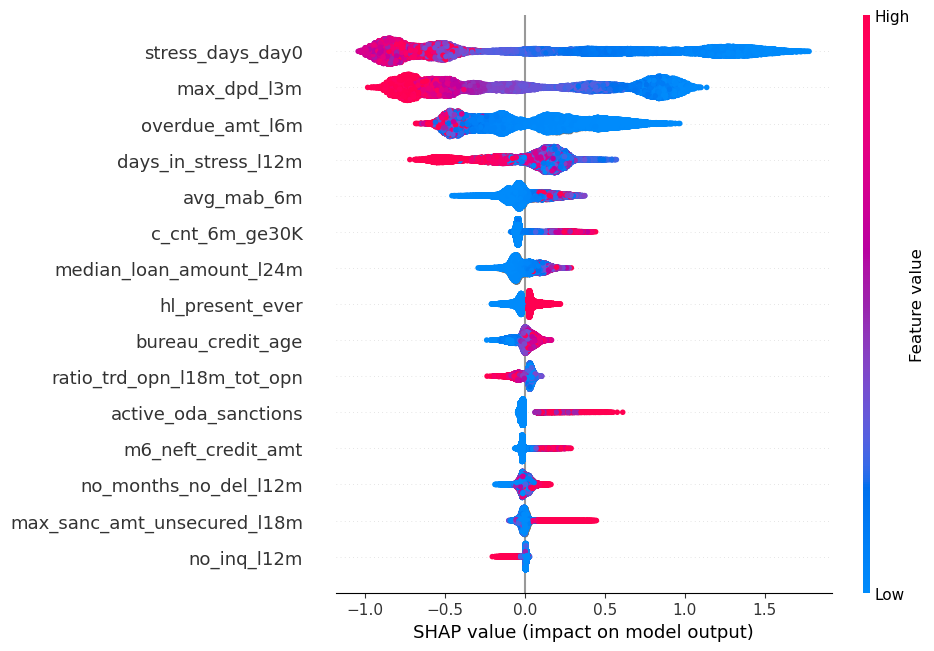

In [72]:
# checking if model has learnt on feature trends in expected directions

import shap
explainer = shap.Explainer(xgb_clf)
shap_values = explainer(X_t[model_fts])

shap.plots.beeswarm(shap_values,max_display=40)

In [ ]:
# shap_values.values
# len(shap_values.values)

In [45]:
# deciling the outputs to see rank order, ks etc...

def ks_fn(data, target, prob,cuts):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob], 10,duplicates='drop')
    # print(data['bucket'].value_counts())
    grouped = data.groupby('bucket', as_index=False)
    # print()
    
    
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events'] = grouped.sum()[target]
    kstable['nonevents'] = grouped.sum()['target0']
    
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop=True)
    kstable['event_rate'] =(kstable['events']/(kstable['events']+kstable['nonevents'])).apply('{0:.2%}'.format)
    kstable['event_capture_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_capture_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate'] = (kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate'] = (kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate'] - kstable['cum_noneventrate'], 3) * 100
    
    # Formatting
    kstable['cum_eventrate'] = kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate'] = kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    # print(kstable)
    
    kstable.index = range(1,data['bucket'].nunique()+1)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 20)
    
    # print(kstable)
    
    # Display KS
    print(Fore.RED + "KS is " + str(max(kstable['KS'])) + "%" + " at decile " + str((kstable.index[kstable['KS'] == max(kstable['KS'])][0])))
    
    return kstable


In [73]:

predprob_xg =xgb_clf.predict_proba(X_t[model_fts])[:,1]

X_t['DV']=Y_train
X_t['Prediction']=predprob_xg.tolist()

In [74]:
X_ts.columns

Index(['stress_days_day0', 'ratio_trd_opn_l18m_tot_opn', 'overdue_amt_l6m',
       'no_months_no_del_l12m', 'median_loan_amount_l24m',
       'max_sanc_amt_unsecured_l18m', 'max_dpd_l3m', 'm6_neft_credit_amt',
       'days_in_stress_l12m', 'c_cnt_6m_ge30K', 'avg_mab_6m',
       'active_oda_sanctions', 'bureau_credit_age', 'hl_present_ever',
       'no_inq_l12m'],
      dtype='object')

In [75]:
predprob_xg =xgb_clf.predict_proba(X_ts[model_fts])[:,1]

X_ts['DV']=Y_test

X_ts['Prediction']=predprob_xg.tolist()

In [76]:
X_t.columns

Index(['stress_days_day0', 'ratio_trd_opn_l18m_tot_opn', 'overdue_amt_l6m',
       'no_months_no_del_l12m', 'median_loan_amount_l24m',
       'max_sanc_amt_unsecured_l18m', 'max_dpd_l3m', 'm6_neft_credit_amt',
       'days_in_stress_l12m', 'c_cnt_6m_ge30K', 'avg_mab_6m',
       'active_oda_sanctions', 'bureau_credit_age', 'hl_present_ever',
       'no_inq_l12m', 'DV', 'Prediction'],
      dtype='object')

In [55]:
# checking all performances below including OOT

KS_Table_train =ks_fn(X_t,'DV' ,'Prediction',10).sort_index(ascending = False)
display(KS_Table_train)

KS is 61.5% at decile 5


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
10      0.037077  0.084717     151       2779      5.15%              1.03%   
9       0.084760  0.139015     286       2644      9.76%              1.96%   
8       0.139016  0.213193     504       2425     17.21%              3.45%   
7       0.213203  0.312565     752       2178     25.67%              5.15%   
6       0.312606  0.462070    1110       1820     37.88%              7.60%   
5       0.462101  0.650421    1676       1253     57.22%             11.47%   
4       0.650426  0.786207    2110        820     72.01%             14.44%   
3       0.786261  0.878781    2456        473     83.85%             16.81%   
2       0.878897  0.938365    2722        208     92.90%             18.63%   
1       0.938367  0.985079    2846         84     97.13%             19.48%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
10                    18.93%       100.00%          100.00%  -0.0  
9                     18.01%        98.97%           81.07%  17.9  
8                     16.51%        97.01%           63.07%  33.9  
7                     14.83%        93.56%           46.55%  47.0  
6                     12.39%        88.41%           31.72%  56.7  
5                      8.53%        80.82%           19.33%  61.5  
4                      5.58%        69.35%           10.79%  58.6  
3                      3.22%        54.91%            5.21%  49.7  
2                      1.42%        38.10%            1.99%  36.1  
1                      0.57%        19.48%            0.57%  18.9

In [56]:
# KS_Table_test =KS(X_ts, 'Prediction','DV').sort_index(ascending = False)
KS_Table_test =ks_fn(X_ts,'DV' ,'Prediction',10).sort_index(ascending = False)
display(KS_Table_test)
# display(KS_Table_test)

KS is 60.9% at decile 5


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
10      0.040028  0.083313      67       1189      5.33%              1.07%   
9       0.083388  0.138948     123       1133      9.79%              1.97%   
8       0.138951  0.218057     202       1053     16.10%              3.23%   
7       0.218124  0.320515     331        925     26.35%              5.29%   
6       0.320551  0.477439     495        760     39.44%              7.91%   
5       0.477587  0.658400     691        565     55.02%             11.04%   
4       0.658460  0.781839     903        352     71.95%             14.43%   
3       0.781962  0.873826    1071        185     85.27%             17.11%   
2       0.873909  0.936228    1159         96     92.35%             18.52%   
1       0.936283  0.985328    1217         39     96.89%             19.44%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
10                    18.88%       100.00%          100.00%   0.0  
9                     17.99%        98.93%           81.12%  17.8  
8                     16.72%        96.96%           63.13%  33.8  
7                     14.69%        93.74%           46.40%  47.3  
6                     12.07%        88.45%           31.71%  56.7  
5                      8.97%        80.54%           19.64%  60.9  
4                      5.59%        69.50%           10.67%  58.8  
3                      2.94%        55.07%            5.08%  50.0  
2                      1.52%        37.96%            2.14%  35.8  
1                      0.62%        19.44%            0.62%  18.8

In [57]:
threshold=0.468976
X_t['Y_Pred_New']=np.where(X_t['Prediction']>threshold,1,0)

In [58]:
# threshold=0.5
X_ts['Y_Pred_New']=np.where(X_ts['Prediction']>threshold,1,0)

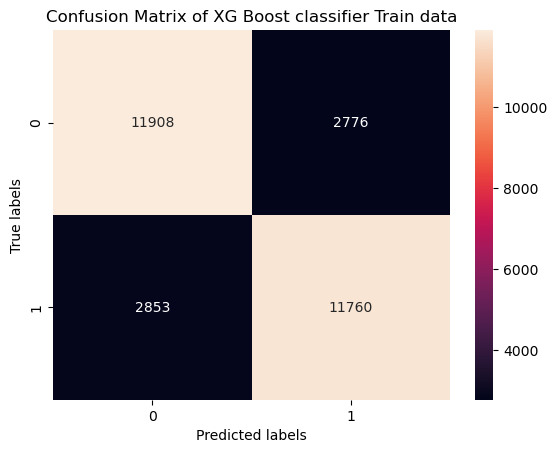

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt


ax=plt.subplot()
sns.heatmap(confusion_matrix(Y_train, X_t['Y_Pred_New']), annot=True, ax=ax, fmt='g')

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix of XG Boost classifier Train data')
ax.xaxis.set_ticklabels(['0','1']); ax.yaxis.set_ticklabels(['0','1']);

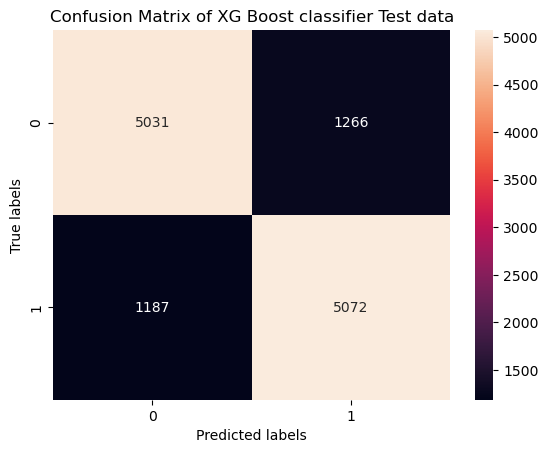

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt


ax=plt.subplot()
sns.heatmap(confusion_matrix(Y_test, X_ts['Y_Pred_New']), annot=True, ax=ax, fmt='g')

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix of XG Boost classifier Test data')
ax.xaxis.set_ticklabels(['0','1']); ax.yaxis.set_ticklabels(['0','1']);

In [61]:
FPR, TPR,_=roc_curve(Y_train, X_t['Y_Pred_New'])

AUC_Train=auc(FPR, TPR)

print('Train AUC :', round(AUC_Train,4))

Train AUC : 0.8079


In [62]:
FPR, TPR,_=roc_curve(Y_test, X_ts['Y_Pred_New'])

AUC_Test=auc(FPR, TPR)

print('Test AUC :', round(AUC_Test,4))

Test AUC : 0.8047


In [63]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print('Accuracy Score in Train:', round((accuracy_score(Y_train, X_t['Y_Pred_New'])),2))
print(classification_report(Y_train, X_t['Y_Pred_New']))

Accuracy Score in Train: 0.81
              precision    recall  f1-score   support

           0       0.81      0.81      0.81     14684
           1       0.81      0.80      0.81     14613

    accuracy                           0.81     29297
   macro avg       0.81      0.81      0.81     29297
weighted avg       0.81      0.81      0.81     29297



In [64]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print('Accuracy Score in Test:', round((accuracy_score(Y_test, X_ts['Y_Pred_New'])),2))
print(classification_report(Y_test, X_ts['Y_Pred_New']))

Accuracy Score in Test: 0.8
              precision    recall  f1-score   support

           0       0.81      0.80      0.80      6297
           1       0.80      0.81      0.81      6259

    accuracy                           0.80     12556
   macro avg       0.80      0.80      0.80     12556
weighted avg       0.80      0.80      0.80     12556



## OOT

In [30]:
import pickle
!pip install xgboost==1.7.5
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.feature_selection import RFE
import xgboost
from xgboost import XGBClassifier
with open('xgb_8jul_cp.pkl', 'rb') as f:
    # Load the pickled dictionary
    xgb_clf = pickle.load(f)



In [31]:
# drop mostly missing columns
print(df_oot.shape)


# df_oot=df_oot.drop([
#     'l3m_deposit_amt',
# 'l3m_deposit_cnt',
# 'l6m_deposit_amt',
# 'l6m_deposit_cnt',
# 'total_promised_paid_l1m',
# 'tot_promised_l1m',
# 'total_promised_paid_l3m',
# 'total_promised_paid_l6m',
# 'month_since_gl_inq_l24m',
# 'tot_promised_l3m',
# 'promised_to_pay_date',
# 'tot_promised_l6m',
# 'tot_promised_amt'],axis=1)

print(df_oot.shape)

(49769, 438)
(49769, 438)


In [32]:
df_oot['c_cnt_6m_ge30K'] =df_oot['c_cnt_6m_30k_50k']+df_oot['c_cnt_6m_50k_75k']+df_oot['c_cnt_6m_75k_1l']+df_oot['c_cnt_6m_1l_and_above']

In [33]:
with open('numeric_cols_cp.pkl', 'rb') as f:
    # Load the pickled dictionary
    numeric_cols = pickle.load(f)
    
with open('cols_bool_cp.pkl', 'rb') as f:
    # Load the pickled dictionary
    cols_bool = pickle.load(f)

with open('percentiles_dict_cp.pkl', 'rb') as f:
    # Load the pickled dictionary
    percentiles_dict = pickle.load(f)

In [37]:
ser_a=pd.Series(numeric_cols)
result = ser_a[ser_a.isin(model_fts)]

for col in result:
    if col not in cols_bool:
        if col in df_oot.columns.to_list():
            # print(col)
            df_oot[col][df_oot[col] <= percentiles_dict.get(col)[0]] = percentiles_dict.get(col)[0]
            df_oot[col][df_oot[col] >= percentiles_dict.get(col)[1]] = percentiles_dict.get(col)[1]
            

active_oda_sanctions
avg_mab_6m
days_in_stress_l12m
max_dpd_l3m
m6_neft_credit_amt
bureau_credit_age
max_sanc_amt_unsecured_l18m
median_loan_amount_l24m
no_inq_l12m
overdue_amt_l6m
ratio_trd_opn_l18m_tot_opn
stress_days_day0
no_months_no_del_l12m


In [38]:
threshold=0.468976
df_oot["Pred_Score"]=xgb_clf.predict_proba(df_oot[model_fts])[:,1]
df_oot['Y_Pred_New']=np.where(df_oot['Pred_Score']>threshold,1,0)

In [39]:
print(xgb_clf.get_xgb_params())

{'objective': 'binary:logistic', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.7, 'eval_metric': 'auc', 'gamma': 1, 'gpu_id': None, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': 0.07, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': 2, 'max_depth': 6, 'max_leaves': None, 'min_child_weight': 55, 'monotone_constraints': None, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': 2, 'reg_lambda': 3, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.75, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'nthread': 8, 'seed': 27}


In [40]:
df_oot['good'].value_counts()

good
1    25223
0    24546
Name: count, dtype: int64

In [41]:
# df_oot['bad'].value_counts()

In [42]:
df_oot.shape[0]

49769

In [65]:
# KS_Table_OOT =decile_report(df_oot, 'Pred_Score','good').sort_index(ascending = False)
# display(KS_Table_OOT)
# oot_months=df_oot['snap_dt'].unique()
# oot_months.sort()
# print(oot_months)
# for i in oot_months:
    # print(f'event rate is : {(df_oot[df_oot.good==1].shape[0])/(df_oot.shape[0])} ')
# print(f'KS for OOT month : {i}')
Oot_t=df_oot.copy()

FPR, TPR,_=roc_curve(Oot_t['good'], Oot_t['Pred_Score'])
AUC_cut=auc(FPR, TPR)
print(classification_report(Oot_t['good'], Oot_t['Y_Pred_New']))
FPR, TPR,_=roc_curve(Oot_t['good'], Oot_t['Pred_Score'])
AUC_cut=auc(FPR, TPR)
print(confusion_matrix(Oot_t['good'], Oot_t['Y_Pred_New']))
print(f'AUC for OOT month is : {AUC_cut} ')
# print(f'AUC for OOT month {i} is : {AUC_cut} ')
print(f'event rate is : {(Oot_t[Oot_t.good==1].shape[0])/(Oot_t.shape[0])} ')
Oot_t=Oot_t[model_fts+["Pred_Score",'good']]
KS_Table_oot =ks_fn(Oot_t,'good' ,'Pred_Score',10).sort_index(ascending = False)
display(KS_Table_oot)
    

              precision    recall  f1-score   support

           0       0.81      0.78      0.79     24546
           1       0.79      0.82      0.81     25223

    accuracy                           0.80     49769
   macro avg       0.80      0.80      0.80     49769
weighted avg       0.80      0.80      0.80     49769

[[19140  5406]
 [ 4477 20746]]
AUC for OOT month is : 0.8717650526665786 
event rate is : 0.506801422572284 
KS is 60.6% at decile 5


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
10      0.036606  0.083099     331       4646      6.65%              1.31%   
9       0.083111  0.136198     557       4420     11.19%              2.21%   
8       0.136237  0.218359     850       4127     17.08%              3.37%   
7       0.218396  0.334094    1315       3662     26.42%              5.21%   
6       0.334108  0.525918    2026       2951     40.71%              8.03%   
5       0.525920  0.710365    2955       2021     59.39%             11.72%   
4       0.710386  0.830872    3806       1171     76.47%             15.09%   
3       0.830890  0.906765    4251        726     85.41%             16.85%   
2       0.906772  0.950102    4477        500     89.95%             17.75%   
1       0.950105  0.985597    4655        322     93.53%             18.46%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
10                    18.93%       100.00%          100.00%  -0.0  
9                     18.01%        98.69%           81.07%  17.6  
8                     16.81%        96.48%           63.07%  33.4  
7                     14.92%        93.11%           46.25%  46.9  
6                     12.02%        87.90%           31.33%  56.6  
5                      8.23%        79.86%           19.31%  60.6  
4                      4.77%        68.15%           11.08%  57.1  
3                      2.96%        53.06%            6.31%  46.8  
2                      2.04%        36.21%            3.35%  32.9  
1                      1.31%        18.46%            1.31%  17.1

In [77]:
# KS_Table_OOT =decile_report(df_oot, 'Pred_Score','good').sort_index(ascending = False)
# display(KS_Table_OOT)
oot_months=df_oot['snap_dt'].unique()
oot_months.sort()
# print(oot_months)
for i in oot_months:
    # print(f'event rate is : {(df_oot[df_oot.good==1].shape[0])/(df_oot.shape[0])} ')
    print(f'KS for OOT month : {i}')

    Oot_t=df_oot[df_oot['snap_dt']==i]
    
    FPR, TPR,_=roc_curve(Oot_t['good'], Oot_t['Pred_Score'])
    AUC_cut=auc(FPR, TPR)
    print(classification_report(Oot_t['good'], Oot_t['Y_Pred_New']))
    FPR, TPR,_=roc_curve(Oot_t['good'], Oot_t['Pred_Score'])
    AUC_cut=auc(FPR, TPR)
    # print(f'AUC for OOT month {i} is : {AUC_cut} ')
    print(f'AUC for OOT month {i} is : {AUC_cut} ')
    print(f'event rate is : {(Oot_t[Oot_t.good==1].shape[0])/(Oot_t.shape[0])} ')
    Oot_t=Oot_t[model_fts+["Pred_Score",'good']]
    KS_Table_oot =ks_fn(Oot_t,'good' ,'Pred_Score',10).sort_index(ascending = False)
    display(KS_Table_oot)
    

KS for OOT month : 2023-01-31
              precision    recall  f1-score   support

           0       0.83      0.79      0.81      3860
           1       0.79      0.83      0.81      3782

    accuracy                           0.81      7642
   macro avg       0.81      0.81      0.81      7642
weighted avg       0.81      0.81      0.81      7642

AUC for OOT month 2023-01-31 is : 0.8875799053602693 
event rate is : 0.49489662392043965 
KS is 62.9% at decile 5


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
10      0.041243  0.116856      40        725      5.23%              1.06%   
9       0.116942  0.186428      66        698      8.64%              1.75%   
8       0.186439  0.260648     111        653     14.53%              2.93%   
7       0.260796  0.356827     179        585     23.43%              4.73%   
6       0.356827  0.512422     293        471     38.35%              7.75%   
5       0.512607  0.686279     448        316     58.64%             11.85%   
4       0.686326  0.807145     568        196     74.35%             15.02%   
3       0.807455  0.889475     637        127     83.38%             16.84%   
2       0.889651  0.942185     697         67     91.23%             18.43%   
1       0.942257  0.982659     743         22     97.12%             19.65%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
10                    18.78%       100.00%          100.00%   0.0  
9                     18.08%        98.94%           81.22%  17.7  
8                     16.92%        97.20%           63.13%  34.1  
7                     15.16%        94.26%           46.22%  48.0  
6                     12.20%        89.53%           31.06%  58.5  
5                      8.19%        81.78%           18.86%  62.9  
4                      5.08%        69.94%           10.67%  59.3  
3                      3.29%        54.92%            5.60%  49.3  
2                      1.74%        38.08%            2.31%  35.8  
1                      0.57%        19.65%            0.57%  19.1

KS for OOT month : 2023-12-31
              precision    recall  f1-score   support

           0       0.81      0.82      0.82      4921
           1       0.83      0.81      0.82      5096

    accuracy                           0.82     10017
   macro avg       0.82      0.82      0.82     10017
weighted avg       0.82      0.82      0.82     10017

AUC for OOT month 2023-12-31 is : 0.8931944981891276 
event rate is : 0.5087351502445842 
KS is 63.6% at decile 5


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
10      0.043905  0.085911      63        939      6.29%              1.24%   
9       0.085920  0.130493      96        906      9.58%              1.88%   
8       0.130654  0.199007     144        857     14.39%              2.83%   
7       0.199059  0.302770     260        742     25.95%              5.10%   
6       0.302783  0.473887     393        609     39.22%              7.71%   
5       0.473922  0.668369     586        415     58.54%             11.50%   
4       0.668391  0.797513     741        261     73.95%             14.54%   
3       0.797529  0.886013     893        108     89.21%             17.52%   
2       0.886155  0.942977     937         65     93.51%             18.39%   
1       0.942992  0.984279     983         19     98.10%             19.29%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
10                    19.08%       100.00%          100.00%  -0.0  
9                     18.41%        98.76%           80.92%  17.8  
8                     17.42%        96.88%           62.51%  34.4  
7                     15.08%        94.05%           45.09%  49.0  
6                     12.38%        88.95%           30.01%  58.9  
5                      8.43%        81.24%           17.64%  63.6  
4                      5.30%        69.74%            9.21%  60.5  
3                      2.19%        55.20%            3.90%  51.3  
2                      1.32%        37.68%            1.71%  36.0  
1                      0.39%        19.29%            0.39%  18.9

KS for OOT month : 2024-01-31
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      5086
           1       0.81      0.81      0.81      4782

    accuracy                           0.81      9868
   macro avg       0.81      0.81      0.81      9868
weighted avg       0.81      0.81      0.81      9868

AUC for OOT month 2024-01-31 is : 0.8883461673765807 
event rate is : 0.48459667612484797 
KS is 62.5% at decile 5


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
10      0.037662  0.074594      56        931      5.67%              1.17%   
9       0.074609  0.118877      85        902      8.61%              1.78%   
8       0.119051  0.187180     155        832     15.70%              3.24%   
7       0.187247  0.287555     217        769     22.01%              4.54%   
6       0.287652  0.444642     337        650     34.14%              7.05%   
5       0.444737  0.641952     515        472     52.18%             10.77%   
4       0.642076  0.784252     706        280     71.60%             14.76%   
3       0.784268  0.876328     843        144     85.41%             17.63%   
2       0.876354  0.936474     911         76     92.30%             19.05%   
1       0.936620  0.985597     957         30     96.96%             20.01%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
10                    18.31%       100.00%          100.00%   0.0  
9                     17.73%        98.83%           81.69%  17.1  
8                     16.36%        97.05%           63.96%  33.1  
7                     15.12%        93.81%           47.60%  46.2  
6                     12.78%        89.27%           32.48%  56.8  
5                      9.28%        82.23%           19.70%  62.5  
4                      5.51%        71.46%           10.42%  61.0  
3                      2.83%        56.69%            4.92%  51.8  
2                      1.49%        39.06%            2.08%  37.0  
1                      0.59%        20.01%            0.59%  19.4

KS for OOT month : 2024-02-29
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      4788
           1       0.84      0.80      0.82      5874

    accuracy                           0.81     10662
   macro avg       0.80      0.81      0.80     10662
weighted avg       0.81      0.81      0.81     10662

AUC for OOT month 2024-02-29 is : 0.8821377619795716 
event rate is : 0.5509285312324141 
KS is 61.1% at decile 5


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
10      0.037597  0.076545      94        973      8.81%              1.60%   
9       0.076576  0.123622     129        937     12.10%              2.20%   
8       0.123690  0.201682     261        805     24.48%              4.44%   
7       0.201737  0.322857     349        717     32.74%              5.94%   
6       0.322907  0.518393     491        575     46.06%              8.36%   
5       0.518425  0.709958     669        397     62.76%             11.39%   
4       0.710395  0.834576     865        201     81.14%             14.73%   
3       0.834635  0.908384     954        112     89.49%             16.24%   
2       0.908396  0.950114    1007         59     94.47%             17.14%   
1       0.950118  0.985593    1055         12     98.88%             17.96%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
10                    20.32%       100.00%          100.00%   0.0  
9                     19.57%        98.40%           79.68%  18.7  
8                     16.81%        96.20%           60.11%  36.1  
7                     14.97%        91.76%           43.30%  48.5  
6                     12.01%        85.82%           28.32%  57.5  
5                      8.29%        77.46%           16.31%  61.1  
4                      4.20%        66.07%            8.02%  58.1  
3                      2.34%        51.34%            3.82%  47.5  
2                      1.23%        35.10%            1.48%  33.6  
1                      0.25%        17.96%            0.25%  17.7

KS for OOT month : 2024-03-31
              precision    recall  f1-score   support

           0       0.83      0.68      0.75      5891
           1       0.72      0.86      0.78      5689

    accuracy                           0.77     11580
   macro avg       0.78      0.77      0.77     11580
weighted avg       0.78      0.77      0.76     11580

AUC for OOT month 2024-03-31 is : 0.8357810739955981 
event rate is : 0.4912780656303972 
KS is 54.900000000000006% at decile 5


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
10      0.036606  0.079479      80       1078      6.91%              1.41%   
9       0.079480  0.139557     131       1027     11.31%              2.30%   
8       0.139803  0.253624     211        947     18.22%              3.71%   
7       0.253747  0.428356     330        828     28.50%              5.80%   
6       0.428450  0.654613     503        655     43.44%              8.84%   
5       0.654851  0.810381     732        426     63.21%             12.87%   
4       0.810462  0.894411     858        300     74.09%             15.08%   
3       0.894489  0.936552     900        258     77.72%             15.82%   
2       0.936602  0.960681     934        224     80.66%             16.42%   
1       0.960700  0.984550    1010        148     87.22%             17.75%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
10                    18.30%       100.00%          100.00%   0.0  
9                     17.43%        98.59%           81.70%  16.9  
8                     16.08%        96.29%           64.27%  32.0  
7                     14.06%        92.58%           48.19%  44.4  
6                     11.12%        86.78%           34.14%  52.6  
5                      7.23%        77.94%           23.02%  54.9  
4                      5.09%        65.07%           15.79%  49.3  
3                      4.38%        49.99%           10.69%  39.3  
2                      3.80%        34.17%            6.31%  27.9  
1                      2.51%        17.75%            2.51%  15.2

In [78]:
oot_cat=df_oot['stress_cat_day0'].unique()
oot_cat.sort()
# stress_cat_day0
# print(oot_cat)
for i in oot_cat:
    if i=='SMA0':
        threshold=0.782977
    elif i=='SMA1':
        threshold=0.237081
    else:
        threshold=0.134735
    df_oot['Y_Pred_New']=np.where(df_oot['Pred_Score']>threshold,1,0)
    print(f'KS for OOT bucket : {i}')
    Oot_t=df_oot[df_oot['stress_cat_day0']==i]
    Oot_t=Oot_t[model_fts+["Pred_Score",'good','Y_Pred_New']]
    FPR, TPR,_=roc_curve(Oot_t['good'], Oot_t['Pred_Score'])
    print(classification_report(Oot_t['good'], Oot_t['Y_Pred_New']))
    FPR, TPR,_=roc_curve(Oot_t['good'], Oot_t['Pred_Score'])
    AUC_cut=auc(FPR, TPR)
    AUC_cut=auc(FPR, TPR)
    # print(classification_report(Oot_t['good'], Oot_t['Y_Pred_New']))
    print(f'AUC for OOT month {i} is : {AUC_cut} ')
    print(f'event rate is : {(Oot_t[Oot_t.good==1].shape[0])/(Oot_t.shape[0])} ')
    Oot_t=Oot_t[model_fts+["Pred_Score",'good']]
    KS_Table_oot =ks_fn(Oot_t,'good' ,'Pred_Score',10).sort_index(ascending = False)
    display(KS_Table_oot)

KS for OOT bucket : SMA0
              precision    recall  f1-score   support

           0       0.45      0.72      0.55      7122
           1       0.88      0.71      0.78     21548

    accuracy                           0.71     28670
   macro avg       0.67      0.71      0.67     28670
weighted avg       0.78      0.71      0.73     28670

AUC for OOT month SMA0 is : 0.7742764245645921 
event rate is : 0.7515870247645623 
KS is 42.5% at decile 6


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
10      0.095183  0.457197     989       1878     34.50%              4.59%   
9       0.457320  0.599479    1461       1406     50.96%              6.78%   
8       0.599486  0.705341    1815       1052     63.31%              8.42%   
7       0.705358  0.782967    2077        790     72.45%              9.64%   
6       0.782977  0.841492    2322        545     80.99%             10.78%   
5       0.841499  0.887658    2442        425     85.18%             11.33%   
4       0.887660  0.920937    2519        348     87.86%             11.69%   
3       0.920973  0.944700    2585        282     90.16%             12.00%   
2       0.944701  0.963295    2622        245     91.45%             12.17%   
1       0.963299  0.985597    2716        151     94.73%             12.60%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
10                    26.37%       100.00%          100.00%   0.0  
9                     19.74%        95.41%           73.63%  21.8  
8                     14.77%        88.63%           53.89%  34.7  
7                     11.09%        80.21%           39.12%  41.1  
6                      7.65%        70.57%           28.03%  42.5  
5                      5.97%        59.79%           20.37%  39.4  
4                      4.89%        48.46%           14.41%  34.1  
3                      3.96%        36.77%            9.52%  27.2  
2                      3.44%        24.77%            5.56%  19.2  
1                      2.12%        12.60%            2.12%  10.5

KS for OOT bucket : SMA1
              precision    recall  f1-score   support

           0       0.87      0.66      0.75      7403
           1       0.31      0.61      0.42      1906

    accuracy                           0.65      9309
   macro avg       0.59      0.63      0.58      9309
weighted avg       0.75      0.65      0.68      9309

AUC for OOT month SMA1 is : 0.681983949390076 
event rate is : 0.2047480932430981 
KS is 26.900000000000002% at decile 4


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
10      0.037885  0.080749      57        874      6.12%              2.99%   
9       0.080759  0.106634      93        838      9.99%              4.88%   
8       0.106692  0.136582     115        816     12.35%              6.03%   
7       0.136616  0.165994     131        800     14.07%              6.87%   
6       0.166085  0.199501     156        775     16.76%              8.18%   
5       0.199501  0.237025     184        746     19.78%              9.65%   
4       0.237081  0.279443     236        695     25.35%             12.38%   
3       0.279459  0.325484     248        683     26.64%             13.01%   
2       0.325487  0.395270     301        630     32.33%             15.79%   
1       0.395284  0.791355     385        546     41.35%             20.20%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
10                    11.81%       100.00%          100.00%   0.0  
9                     11.32%        97.01%           88.19%   8.8  
8                     11.02%        92.13%           76.87%  15.3  
7                     10.81%        86.10%           65.85%  20.2  
6                     10.47%        79.22%           55.05%  24.2  
5                     10.08%        71.04%           44.58%  26.5  
4                      9.39%        61.39%           34.50%  26.9  
3                      9.23%        49.00%           25.11%  23.9  
2                      8.51%        35.99%           15.89%  20.1  
1                      7.38%        20.20%            7.38%  12.8

KS for OOT bucket : SMA2
              precision    recall  f1-score   support

           0       0.91      0.64      0.76     10021
           1       0.25      0.65      0.36      1769

    accuracy                           0.65     11790
   macro avg       0.58      0.65      0.56     11790
weighted avg       0.81      0.65      0.70     11790

AUC for OOT month SMA2 is : 0.7037043576493884 
event rate is : 0.15004240882103478 
KS is 30.2% at decile 3


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
10      0.036606  0.057034      61       1118      5.17%              3.45%   
9       0.057038  0.067130      84       1095      7.12%              4.75%   
8       0.067135  0.078360      92       1087      7.80%              5.20%   
7       0.078363  0.092439     102       1077      8.65%              5.77%   
6       0.092449  0.110290     117       1062      9.92%              6.61%   
5       0.110292  0.134735     157       1022     13.32%              8.88%   
4       0.134735  0.168820     171       1008     14.50%              9.67%   
3       0.168822  0.217225     229        950     19.42%             12.95%   
2       0.217236  0.294139     303        876     25.70%             17.13%   
1       0.294268  0.674582     453        726     38.42%             25.61%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
10                    11.16%       100.00%          100.00%   0.0  
9                     10.93%        96.55%           88.84%   7.7  
8                     10.85%        91.80%           77.92%  13.9  
7                     10.75%        86.60%           67.07%  19.5  
6                     10.60%        80.84%           56.32%  24.5  
5                     10.20%        74.22%           45.72%  28.5  
4                     10.06%        65.35%           35.53%  29.8  
3                      9.48%        55.68%           25.47%  30.2  
2                      8.74%        42.74%           15.99%  26.7  
1                      7.24%        25.61%            7.24%  18.4

In [79]:
df_oot['exposure_bucket'] = pd.qcut(df_oot['exposure'], 4,duplicates='drop')
# df_oot['exposure_bucket'].value_counts()
threshold=0.468976
# df_oot["Pred_Score"]=xgb_clf.predict_proba(df_oot[model_fts])[:,1]
df_oot['Y_Pred_New']=np.where(df_oot['Pred_Score']>threshold,1,0)

In [80]:
oot_cat=df_oot['exposure_bucket'].unique()
# oot_cat.sort()
# stress_cat_day0
# print(oot_cat)
for i in oot_cat:
    if i is not np.nan:
        print(f'KS for OOT bucket : {i}')
        Oot_t=df_oot[df_oot['exposure_bucket']==i]
        Oot_t=Oot_t[model_fts+["Pred_Score",'good']]
        FPR, TPR,_=roc_curve(Oot_t['good'], Oot_t['Pred_Score'])
        AUC_cut=auc(FPR, TPR)
        print(f'AUC for OOT month {i} is : {AUC_cut} ')
        print(f'event rate is : {(Oot_t[Oot_t.good==1].shape[0])/(Oot_t.shape[0])} ')
        KS_Table_oot =ks_fn(Oot_t,'good' ,'Pred_Score',10).sort_index(ascending = False)
        display(KS_Table_oot)


KS for OOT bucket : (860965.665, 2337005.968]
AUC for OOT month (860965.665, 2337005.968] is : 0.8823112349996187 
event rate is : 0.5247246120447053 
KS is 62.4% at decile 5


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
10      0.037792  0.075826      70       1174      5.63%              1.07%   
9       0.075839  0.121005     104       1140      8.36%              1.59%   
8       0.121038  0.201057     201       1042     16.17%              3.08%   
7       0.201080  0.342502     352        892     28.30%              5.39%   
6       0.342591  0.581927     600        644     48.23%              9.19%   
5       0.581931  0.759226     828        415     66.61%             12.69%   
4       0.759418  0.859262    1019        225     81.91%             15.61%   
3       0.859281  0.922160    1079        164     86.81%             16.53%   
2       0.922207  0.955559    1121        123     90.11%             17.18%   
1       0.955641  0.982646    1152         92     92.60%             17.65%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
10                    19.86%       100.00%          100.00%  -0.0  
9                     19.29%        98.93%           80.14%  18.8  
8                     17.63%        97.33%           60.85%  36.5  
7                     15.09%        94.25%           43.22%  51.0  
6                     10.89%        88.86%           28.13%  60.7  
5                      7.02%        79.67%           17.24%  62.4  
4                      3.81%        66.98%           10.22%  56.8  
3                      2.77%        51.36%            6.41%  45.0  
2                      2.08%        34.83%            3.64%  31.2  
1                      1.56%        17.65%            1.56%  16.1

KS for OOT bucket : (244465.808, 860965.665]
AUC for OOT month (244465.808, 860965.665] is : 0.8709401518685708 
event rate is : 0.47117472059178256 
KS is 60.6% at decile 5


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
10      0.037662  0.075285      74       1170      5.95%              1.26%   
9       0.075305  0.119087     125       1119     10.05%              2.13%   
8       0.119116  0.182471     164       1079     13.19%              2.80%   
7       0.182509  0.278953     274        970     22.03%              4.68%   
6       0.279108  0.442582     416        828     33.44%              7.10%   
5       0.442659  0.656874     671        572     53.98%             11.45%   
4       0.656933  0.804865     886        358     71.22%             15.12%   
3       0.804948  0.893292    1002        241     80.61%             17.10%   
2       0.893342  0.942196    1096        148     88.10%             18.70%   
1       0.942220  0.982659    1152         92     92.60%             19.66%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
10                    17.79%       100.00%          100.00%   0.0  
9                     17.01%        98.74%           82.21%  16.5  
8                     16.41%        96.60%           65.20%  31.4  
7                     14.75%        93.81%           48.79%  45.0  
6                     12.59%        89.13%           34.04%  55.1  
5                      8.70%        82.03%           21.45%  60.6  
4                      5.44%        70.58%           12.76%  57.8  
3                      3.66%        55.46%            7.31%  48.1  
2                      2.25%        38.36%            3.65%  34.7  
1                      1.40%        19.66%            1.40%  18.3

KS for OOT bucket : (0.999, 244465.808]
AUC for OOT month (0.999, 244465.808] is : 0.8390948412662429 
event rate is : 0.4784111924097451 
KS is 52.900000000000006% at decile 4


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
10      0.038661  0.095755     107       1137      8.60%              1.80%   
9       0.095945  0.164984     186       1058     14.95%              3.13%   
8       0.164997  0.255427     267        976     21.48%              4.49%   
7       0.255530  0.342477     317        927     25.48%              5.33%   
6       0.342616  0.457324     456        788     36.66%              7.66%   
5       0.457357  0.620380     595        648     47.87%             10.00%   
4       0.620390  0.754741     790        454     63.50%             13.28%   
3       0.754923  0.847977     993        250     79.89%             16.69%   
2       0.848046  0.913594    1086        158     87.30%             18.25%   
1       0.913708  0.982245    1153         91     92.68%             19.38%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
10                    17.53%       100.00%          100.00%  -0.0  
9                     16.31%        98.20%           82.47%  15.7  
8                     15.05%        95.08%           66.16%  28.9  
7                     14.29%        90.59%           51.12%  39.5  
6                     12.15%        85.26%           36.83%  48.4  
5                      9.99%        77.60%           24.68%  52.9  
4                      7.00%        67.60%           14.69%  52.9  
3                      3.85%        54.32%            7.69%  46.6  
2                      2.44%        37.63%            3.84%  33.8  
1                      1.40%        19.38%            1.40%  18.0

KS for OOT bucket : (2337005.968, 74868164.93]
AUC for OOT month (2337005.968, 74868164.93] is : 0.8860298797363684 
event rate is : 0.55342928358929 
KS is 63.6% at decile 5


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
10      0.036606  0.090602     104       1140      8.36%              1.51%   
9       0.090721  0.147445     148       1096     11.90%              2.15%   
8       0.147626  0.238733     209       1034     16.81%              3.04%   
7       0.238754  0.402526     369        875     29.66%              5.36%   
6       0.402551  0.635647     657        587     52.81%              9.55%   
5       0.636391  0.793671     882        361     70.96%             12.81%   
4       0.793682  0.891196    1074        170     86.33%             15.60%   
3       0.891202  0.940428    1101        142     88.58%             16.00%   
2       0.940462  0.966744    1151         93     92.52%             16.72%   
1       0.966762  0.985597    1188         56     95.50%             17.26%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
10                    20.53%       100.00%          100.00%  -0.0  
9                     19.73%        98.49%           79.47%  19.0  
8                     18.62%        96.34%           59.74%  36.6  
7                     15.75%        93.30%           41.12%  52.2  
6                     10.57%        87.94%           25.37%  62.6  
5                      6.50%        78.40%           14.80%  63.6  
4                      3.06%        65.58%            8.30%  57.3  
3                      2.56%        49.98%            5.24%  44.7  
2                      1.67%        33.98%            2.68%  31.3  
1                      1.01%        17.26%            1.01%  16.3

In [81]:
df_oot.columns


Index(['cust_id', 'snap_dt', 'good', 'dev', 'active_loans',
       'active_loans_outstanding', 'active_loans_sanctions',
       'active_oda_outstanding', 'active_oda_sanctions',
       'avg_followups_perdelq_l1m',
       ...
       'max_follow_up_l1m_A002', 'max_follow_up_l1m_A005', '',
       'stress_cat_1to30', 'stress_cat_31to60', 'stress_cat_61to90',
       'c_cnt_6m_ge30K', 'Pred_Score', 'Y_Pred_New', 'exposure_bucket'],
      dtype='object', length=442)

In [82]:
# oot_cat=df_oot['retail_flag'].unique()
# oot_cat.sort()
# stress_cat_day0
# print(oot_cat)

print('KS for OOT bucket : retail')
Oot_t=df_oot[df_oot['retail_flag']==1]
Oot_t=Oot_t[model_fts+["Pred_Score",'good','Y_Pred_New']]
FPR, TPR,_=roc_curve(Oot_t['good'], Oot_t['Pred_Score'])
FPR, TPR,_=roc_curve(Oot_t['good'], Oot_t['Pred_Score'])
print(classification_report(Oot_t['good'], Oot_t['Y_Pred_New']))
AUC_cut=auc(FPR, TPR)
print(f'AUC for OOT month retail is : {AUC_cut} ')
print(f'event rate is : {(Oot_t[Oot_t.good==1].shape[0])/(Oot_t.shape[0])} ')
KS_Table_oot =ks_fn(Oot_t,'good' ,'Pred_Score',10).sort_index(ascending = False)
display(KS_Table_oot)

print('KS for OOT bucket : msme')
Oot_t=df_oot[df_oot['msme_loan']==1]
Oot_t=Oot_t[model_fts+["Pred_Score",'good','Y_Pred_New']]
FPR, TPR,_=roc_curve(Oot_t['good'], Oot_t['Pred_Score'])
FPR, TPR,_=roc_curve(Oot_t['good'], Oot_t['Pred_Score'])
print(classification_report(Oot_t['good'], Oot_t['Y_Pred_New']))
AUC_cut=auc(FPR, TPR)
print(f'AUC for OOT month msme is : {AUC_cut} ')
print(f'event rate is : {(Oot_t[Oot_t.good==1].shape[0])/(Oot_t.shape[0])} ')
KS_Table_oot =ks_fn(Oot_t,'good' ,'Pred_Score',10).sort_index(ascending = False)
display(KS_Table_oot)


KS for OOT bucket : retail
              precision    recall  f1-score   support

           0       0.81      0.78      0.80     19027
           1       0.81      0.84      0.82     20683

    accuracy                           0.81     39710
   macro avg       0.81      0.81      0.81     39710
weighted avg       0.81      0.81      0.81     39710

AUC for OOT month retail is : 0.8774591498609143 
event rate is : 0.5208511709896751 
KS is 62.1% at decile 5


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
10      0.036606  0.081952     257       3714      6.47%              1.24%   
9       0.081954  0.132747     438       3533     11.03%              2.12%   
8       0.132753  0.212370     655       3316     16.49%              3.17%   
7       0.212428  0.336416    1064       2907     26.79%              5.14%   
6       0.336519  0.558943    1778       2193     44.77%              8.60%   
5       0.559088  0.743549    2570       1401     64.72%             12.43%   
4       0.743583  0.852100    3192        779     80.38%             15.43%   
3       0.852113  0.917718    3443        528     86.70%             16.65%   
2       0.917720  0.954572    3573        398     89.98%             17.28%   
1       0.954576  0.985597    3713        258     93.50%             17.95%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
10                    19.52%       100.00%          100.00%   0.0  
9                     18.57%        98.76%           80.48%  18.3  
8                     17.43%        96.64%           61.91%  34.7  
7                     15.28%        93.47%           44.48%  49.0  
6                     11.53%        88.33%           29.21%  59.1  
5                      7.36%        79.73%           17.68%  62.1  
4                      4.09%        67.31%           10.32%  57.0  
3                      2.78%        51.87%            6.22%  45.7  
2                      2.09%        35.23%            3.45%  31.8  
1                      1.36%        17.95%            1.36%  16.6

KS for OOT bucket : msme
              precision    recall  f1-score   support

           0       0.79      0.76      0.78      6211
           1       0.75      0.77      0.76      5620

    accuracy                           0.77     11831
   macro avg       0.77      0.77      0.77     11831
weighted avg       0.77      0.77      0.77     11831

AUC for OOT month msme is : 0.8481505662952481 
event rate is : 0.4750232440199476 
KS is 54.0% at decile 4


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
10      0.037662  0.090682     100       1084      8.45%              1.78%   
9       0.090697  0.157933     148       1035     12.51%              2.63%   
8       0.157951  0.249491     236        947     19.95%              4.20%   
7       0.249549  0.342131     308        875     26.04%              5.48%   
6       0.342145  0.455613     435        748     36.77%              7.74%   
5       0.455632  0.621148     552        631     46.66%              9.82%   
4       0.621210  0.755232     742        441     62.72%             13.20%   
3       0.755356  0.855013     934        249     78.95%             16.62%   
2       0.855041  0.927949    1034        149     87.40%             18.40%   
1       0.927966  0.985597    1131         52     95.60%             20.12%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
10                    17.45%       100.00%          100.00%   0.0  
9                     16.66%        98.22%           82.55%  15.7  
8                     15.25%        95.59%           65.88%  29.7  
7                     14.09%        91.39%           50.64%  40.8  
6                     12.04%        85.91%           36.55%  49.4  
5                     10.16%        78.17%           24.50%  53.7  
4                      7.10%        68.35%           14.35%  54.0  
3                      4.01%        55.14%            7.25%  47.9  
2                      2.40%        38.52%            3.24%  35.3  
1                      0.84%        20.12%            0.84%  19.3

In [83]:
threshold=0.5
df_oot['Y_Pred_New']=np.where(df_oot['Pred_Score']>threshold,1,0)

In [84]:
FPR, TPR,_=roc_curve(df_oot['good'], df_oot['Y_Pred_New'])

AUC_Train=auc(FPR, TPR)

print('OOT AUC :', round(AUC_Train,4))

OOT AUC : 0.8019


In [85]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print('Accuracy Score in OOT:', round((accuracy_score(df_oot['good'], df_oot['Y_Pred_New'])),2))
print(classification_report(df_oot['good'], df_oot['Y_Pred_New']))

Accuracy Score in OOT: 0.8
              precision    recall  f1-score   support

           0       0.80      0.79      0.80     24546
           1       0.80      0.81      0.81     25223

    accuracy                           0.80     49769
   macro avg       0.80      0.80      0.80     49769
weighted avg       0.80      0.80      0.80     49769



In [86]:
def lift_chart(X,actual_target,model):
    avg_tgt = actual_target.sum()/len(actual_target)
    df_data = X.copy()
    X_data = df_data.copy()
    df_data['Actual'] = actual_target
    df_data['Predict']= model.predict(X_data)
    y_Prob = pd.DataFrame(model.predict_proba(X_data))
    df_data['Prob_1']=list(y_Prob[1])
    df_data.sort_values(by=['Prob_1'],ascending=False,inplace=True)
    df_data.reset_index(drop=True,inplace=True)
    df_data['Decile']=pd.qcut(df_data.index,10,labels=False)
    output_df = pd.DataFrame()
    grouped = df_data.groupby('Decile',as_index=False)
    output_df['Max_Scr']=grouped.max().Prob_1
    output_df['Min_Scr']=grouped.min().Prob_1
    output_df['Actual']=grouped.sum().Actual
    output_df['Total']=grouped.count().Actual
    output_df["Population_perc"] = (output_df["Total"]/len(actual_target))*100
    output_df['Per_Events'] = (output_df['Actual']/output_df['Actual'].sum())*100
    output_df['Gain_Percentage'] = output_df.Per_Events.cumsum()
    output_df["Cumulative_Population"] = output_df.Population_perc.cumsum()
    output_df["Lift"] = output_df["Gain_Percentage"]/output_df["Cumulative_Population"]
    return output_df

In [87]:
lift_oot =lift_chart(df_oot[model_fts],df_oot['good'],xgb_clf)

In [88]:
lift_oot.head(10)

Max_Scr   Min_Scr  Actual  Total  Population_perc  Per_Events  \
0  0.985597  0.950105    4655   4977        10.000201   18.455378   
1  0.950102  0.906772    4477   4977        10.000201   17.749673   
2  0.906765  0.830890    4251   4977        10.000201   16.853665   
3  0.830872  0.710386    3806   4977        10.000201   15.089403   
4  0.710365  0.525918    2955   4977        10.000201   11.715498   
5  0.525803  0.334108    2026   4976         9.998192    8.032351   
6  0.334094  0.218396    1315   4977        10.000201    5.213496   
7  0.218359  0.136237     850   4977        10.000201    3.369940   
8  0.136198  0.083111     557   4977        10.000201    2.208302   
9  0.083099  0.036606     331   4977        10.000201    1.312294   

   Gain_Percentage  Cumulative_Population      Lift  
0        18.455378              10.000201  1.845501  
1        36.205051              20.000402  1.810216  
2        53.058716              30.000603  1.768588  
3        68.148119              40.000804  1.703669  
4        79.863617              50.001005  1.597240  
5        87.895968              59.999196  1.464952  
6        93.109464              69.999397  1.330147  
7        96.479404              79.999598  1.205999  
8        98.687706              89.999799  1.096533  
9       100.000000             100.000000  1.000000

In [89]:
# pickling part keep this commented unless you are saving the model to avoid overwrite

# with open('xgb_8jul_cp.pkl', 'wb') as f:
#     pickle.dump(xgb_clf, f)

# pickle.dump(xgb_clf)

In [ ]:
# pip install statsmodels==0.14.0

In [ ]:


# with open('xgb_1jul_cp.pkl', 'wb') as f:
#     pickle.dump(xgb_clf, f)

# pickle.dump(xgb_clf)